<a href="https://www.kaggle.com/code/sherlock9/attention-is-all-you-need?scriptVersionId=296308969" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Attention Is All You Need


_This notebook demonstrates the implementation of Transformers architecture proposed by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762) for neural machine translation (NMT)._


> _Sequence-to-sequence models are deep learning models that have achieved a lot of success in tasks like machine translation, text summarization, and image captioning. Google Translate started [using](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/) such a model in production in late 2016. These models are explained in the two pioneering papers ([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf), [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)). (Excerpt from a [blog post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) by Jay Alammar)_

Sequence-to-sequence (aka seq2seq) model is an end-to-end deep learning model which transforms one sequence to another. It consists of two recurrent neural networks:
- encoder, which encodes an input sequence of variable size into a context vector of fixed size
- decoder, which unfolds the context vector into a new sequence (output).

![seq2seq model](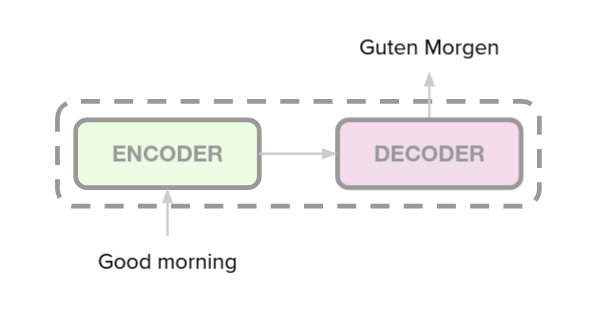 "Seq2Seq Model")


### Seq2Seq Neural Machine Translation (NMT)

A Seq2Seq NMT model can be viewed as an **autoregressive conditional language model**.  
Given an input sequence \( x \), the decoder generates the target sequence  
$$  y = (y_1, y_2, \ldots, y_T) $$ token by token, where each token depends on the input
sequence and all previously generated tokens.

Mathematically, the conditional probability of the target sequence is factorized as:

$$
P(y \mid x) = \prod_{t=1}^{T} P(y_t \mid y_1, \ldots, y_{t-1}, x)
$$

where:
- \( x \) is the source (input) sequence  
- \( y_t \) is the target token at time step \( t \)  
- \( T \) is the length of the target sequence  

This autoregressive formulation enables the model to learn long-range dependencies
in the target language while remaining conditioned on the source sequence.


### Attention and Transformers

The **attention mechanism** overcomes a key limitation of vanilla Seq2Seq models by allowing the decoder to selectively focus on different parts of the encoder outputs at each decoding step. Instead of compressing the entire input sequence into a single fixed-length context vector, attention dynamically weights encoder states, enabling better context preservation. This encoder–decoder attention mechanism led to significant performance improvements in machine translation tasks.

**Transformers** are a class of deep learning models that completely eliminate recurrence. Instead, they rely on **self-attention mechanisms** to model global dependencies within input and output sequences in parallel. Due to their efficiency and ability to capture long-range relationships, Transformers have become the de facto standard in Natural Language Processing (NLP) and have achieved state-of-the-art results across a wide range of tasks. Popular language models such as BERT and GPT are built on the Transformer architecture.


In [1]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from datasets import load_dataset

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
!pip install sacrebleu --quiet
import sacrebleu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 3.1 MB/s eta 0:00:00


In [2]:
dataset = load_dataset('bentrevett/multi30k')
#dataset = load_dataset("cfilt/iitb-english-hindi")
dataset

README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [3]:
dataset['train'][25]
#dataset['train'][10]

#plt config

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=12,8
"""#!pip uninstall -y torch torchtext
%pip install torch==2.8.0
%pip install -q torchtext==0.18.0"""
#!python -m spacy download  xx_ent_wiki_sm

'#!pip uninstall -y torch torchtext\n%pip install torch==2.8.0\n%pip install -q torchtext==0.18.0'

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [5]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_data=dataset['train']
test_data=dataset['test']
valid_data=dataset['validation']

In [8]:
!pip install -q sentencepiece

import sentencepiece as spm
import os
import warnings
warnings.filterwarnings("ignore")

with open('/kaggle/working/train.en', 'w', encoding='utf-8') as f_en, \
     open('/kaggle/working/train.de', 'w', encoding='utf-8') as f_de:
    
    for ex in train_data:
        f_en.write(ex['en'].lower() + '\n')
        f_de.write(ex['de'] + '\n')

spm.SentencePieceTrainer.train(
    input='/kaggle/working/train.en,/kaggle/working/train.de',
    model_prefix='/kaggle/working/spm_en_de',
    vocab_size=16000,
    model_type='unigram',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

sp = spm.SentencePieceProcessor(
    model_file='/kaggle/working/spm_en_de.model'
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/working/train.en
  input: /kaggle/working/train.de
  input_format: 
  model_prefix: /kaggle/working/spm_en_de
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <p

In [9]:
train_data['en'][1]

'Several men in hard hats are operating a giant pulley system.'

In [10]:
train_data

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
})

In [11]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [12]:
sp = spm.SentencePieceProcessor()
#sp.load("/kaggle/input/sp-model/spm_en_de.model")
sp.load('/kaggle/working/spm_en_de.model')
"""encode(...)            # general-purpose, configurable
encode_as_ids(...)     # shortcut for encode(..., out_type=int)
encode_as_pieces(...)  # shortcut for encode(..., out_type=str)
"""

def tokenize_en(text):
  """ Translated english text sequence into a list of tokens.
  """
  return sp.encode(text.lower(), out_type=int)
def tokenize_hi(text):
  """ Translated hindi text sequence into a list of tokens.
  """
  return sp.encode(text, out_type=int)

PAD_IDX= sp.pad_id()
SOS_ID = sp.bos_id()
EOS_IDX = sp.eos_id()
UNK_IDX = sp.unk_id()

VOCAB_SIZE = sp.get_piece_size()

print(f'English vocabulary: {VOCAB_SIZE} words')
print(f'French vocabulary: {VOCAB_SIZE} words')

print(f'# of training examples: {len(train_data)}')
print(f'# of testing examples: {len(test_data)}')
print(f'# of validation examples: {len(valid_data)}')

print(train_data[0].keys())
print(train_data[0])

English vocabulary: 16000 words
French vocabulary: 16000 words
# of training examples: 29000
# of testing examples: 1000
# of validation examples: 1014
dict_keys(['en', 'de'])
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [13]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [14]:
from datasets import disable_caching
disable_caching()

def encode(batch):
    # batch['translation'] is a LIST of dicts
    src = [tokenize_en(x) for x in batch['en']]
    trg = [tokenize_hi(x) for x in batch['de']]

    return  {
        'src': src,
        'trg': trg,
        'src_len': [len(s) for s in src],
        'trg_len': [len(t) for t in trg]
    }

train_encoded = train_data.map(
    encode,
    batched=True,
    batch_size=1000,
    remove_columns=train_data.column_names,
    desc="Encoding Train data"
)


Encoding Train data:   0%|          | 0/29000 [00:00<?, ? examples/s]

In [15]:
test_encoded = test_data.map(
    encode,
    batched=True,
    batch_size=1000,
    desc="Encoding Test data",
    remove_columns=test_data.column_names
)
valid_encoded = valid_data.map(
    encode,
    batched=True,
    batch_size=1000,
    desc="Encoding Valid data",
    remove_columns=valid_data.column_names
)

Encoding Test data:   0%|          | 0/1000 [00:00<?, ? examples/s]

Encoding Valid data:   0%|          | 0/1014 [00:00<?, ? examples/s]

In [16]:
from datasets import load_from_disk
train_encoded.save_to_disk('/kaggle/working/train_encoded')
valid_encoded.save_to_disk('/kaggle/working/valid_encoded')
test_encoded.save_to_disk('/kaggle/working/test_encoded')

Saving the dataset (0/1 shards):   0%|          | 0/29000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1014 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [17]:
"""train_encoded = load_from_disk('/kaggle/working/train_encoded')
valid_encoded = load_from_disk('/kaggle/working/valid_encoded')
test_encoded  = load_from_disk('/kaggle/working/test_encoded')"""


"train_encoded = load_from_disk('/kaggle/working/train_encoded')\nvalid_encoded = load_from_disk('/kaggle/working/valid_encoded')\ntest_encoded  = load_from_disk('/kaggle/working/test_encoded')"

In [18]:
#valid_encoded

In [19]:
import torch
from torch.utils.data import Sampler
import random
class BucketBatchSampler(Sampler):
  def __init__(self,data,batch_size,shuffle=True):
    self.batch_size=batch_size
    self.shuffle=shuffle
    self.indices=list(range(len(data)))
    self.lengths=[sample['src_len'] for sample in data]

  def __iter__(self):
    if self.shuffle:
      random.shuffle(self.indices)

    self.indices.sort(key=lambda i:self.lengths[i])

    batches=[
        self.indices[i:i+self.batch_size]
        for i in range(0,len(self.indices),self.batch_size)
    ]
    if self.shuffle:
      random.shuffle(batches)
    for batch in batches:
      yield batch
  def __len__(self):
    return len(self.indices)//self.batch_size

In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    src_tensors = []
    trg_tensors = []

    for sample in batch:
        src = sample['src']#[:MAX_SRC_LEN]
        trg = sample['trg']#[:MAX_TRG_LEN]

        if len(trg) < 2:
            continue

        src_tensors.append(torch.tensor(src, dtype=torch.long))
        trg_tensors.append(torch.tensor(trg, dtype=torch.long))

    # batch might become empty after filtering
    if len(src_tensors) == 0:
        return None

    src_lens = torch.tensor([len(s) for s in src_tensors], dtype=torch.long)
    trg_lens = torch.tensor([len(t) for t in trg_tensors], dtype=torch.long)

    src = pad_sequence(src_tensors, batch_first=True, padding_value=PAD_IDX)
    trg = pad_sequence(trg_tensors, batch_first=True, padding_value=PAD_IDX)

    return (
        src.to(device),
        src_lens.to(device),
        trg.to(device),
        trg_lens.to(device)
    )

In [21]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64
train_iterator = list(DataLoader(
    train_encoded,
    batch_sampler= BucketBatchSampler(train_encoded,BATCH_SIZE,shuffle=True),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
))
valid_iterator = list(DataLoader(
    valid_encoded,
    batch_sampler=BucketBatchSampler(valid_encoded, BATCH_SIZE, shuffle=False),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
))

test_iterator = list(DataLoader(
    test_encoded,
    batch_sampler=BucketBatchSampler(test_encoded, BATCH_SIZE, shuffle=False),
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
))


In [22]:
#sanity check
x=next(iter(train_iterator))

print(f'Source: {x[0].shape} source_lengths: {x[1].shape}')
print(f'Target: {x[2].shape} Target_lengths: {x[3].shape}')

Source: torch.Size([64, 11]) source_lengths: torch.Size([64])
Target: torch.Size([64, 16]) Target_lengths: torch.Size([64])


## Model Architecture
(source: https://arxiv.org/pdf/1706.03762.pdf)

![transformer_model](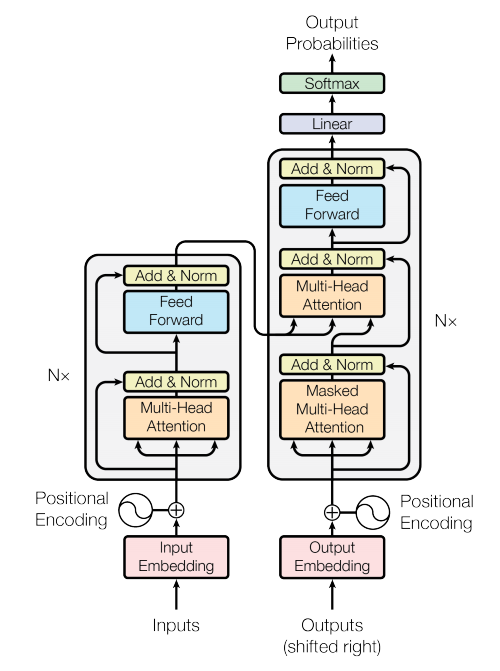 "Transformer Model")


![scaled_dot_product_attention](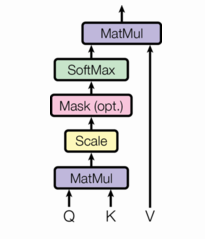 "Scaled Dot-Product Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


> _An attention function can be described as mapping a query and a set of key–value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is determined by a compatibility function between the query and the corresponding key._  
> — *Attention Is All You Need*

In the Transformer architecture, **scaled dot-product attention** is used as the core self-attention mechanism to compute contextualized representations. Given a query matrix \( Q \), key matrix \( K \), and value matrix \( V \), attention is computed by taking the dot product between queries and keys, scaling it by the square root of the key dimension \( \sqrt{d_k} \), applying a softmax to obtain attention weights, and finally using these weights to combine the values.

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
$$

The scaling factor \( \sqrt{d_k} \) is crucial: without it, large dot-product values can push the softmax into regions with extremely small gradients, making optimization unstable. Scaling helps maintain well-behaved gradients during training.

Scaled dot-product attention produces the following outputs:
- **`output`**: the weighted sum of the value vectors, representing the self-attention-based contextual embeddings  
- **`attn_probs`**: the attention (alignment) scores, indicating how strongly each position attends to other positions in the sequence


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
  """
  computes Scaled Dot-product Attention
  """
  def __init__(self,head_dim,dropout_rate=0.2):
    super().__init__()
    self.scale=head_dim ** 0.5
    self.dropout=nn.Dropout(dropout_rate)
  def forward(self,query,key,value,mask=None):
    """
    query : (B,H,Q_len,D)
    key   : (B, H, K_len, D)
    value : (B, H, V_len, D)
    Mask : broadcastable to (B,H,Q_len,K_len)
    """
    #computing QK^T/sqrt(D)
    scores = torch.matmul(query,key.transpose(-2,-1))/self.scale
    #Apply Mask
    if mask is not None:
      mask=mask.bool()
      scores = scores.masked_fill(
          ~mask,
          torch.finfo(scores.dtype).min
      )

    attention_probs = F.softmax(scores,dim=-1)
    attention_probs = self.dropout(attention_probs)

    output = torch.matmul(attention_probs,value)
    return output, attention_probs

### Multi-Head Attention Module
(source: https://arxiv.org/pdf/1706.03762.pdf)

![multi_head_attention](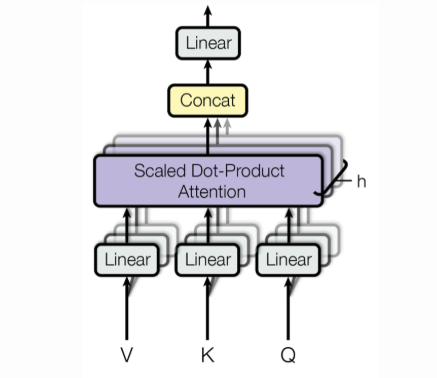 "Multi-Head Attention Block")


Instead of using single self-attention layer, the authors introduced multi-head attention mechanism which simply performs multiple scaled dot-product attention computations in parallel. The authors split queries, keys and values with $d_{model}$ dimension into $h$ heads and then re-combine scaled dot-product computation over each head into a single vector with $d_model$ dimension.

> _Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
W_i^Q \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^K \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^V \in \mathbb{R}^{\mathrm{d_{model}\times d_v}}, W_i^O \in \mathbb{R}^{\mathrm{hd_v\times d_{model}}}
$$

First, the inputs: query matrix $Q$, key matrix $K$ and value matrix $V$ are linearly projected using $W^Q$, $W^K$ and $W^V$. The projected query $QW^Q$, key $KW^K$ and value $VW^V$ are split into $h$ heads. Scaled dot-product attention is computed for each head $i$. The independent attention head computed are then concatenated and linearly projected using $W^O$.

Multi-Head Attention returns the following:
- `x`: context vector concatenated over all the attention heads
- `attn`: alignment scores (attention weights) over all the attention heads


In [24]:
class MultiHeadAttention(nn.Module):
  """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
      refer https://arxiv.org/abs/1706.03762
  """
  def __init__(self,d_model,n_heads,dropout_rate=0.1):
    super().__init__()
    assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"
    self.d_model=d_model
    self.n_heads=n_heads
    self.d_k=d_model//n_heads
    self.dropout_rate = dropout_rate

    self.W_q=nn.Linear(d_model,d_model,bias=False)
    self.W_k = nn.Linear(d_model,d_model,bias=False)
    self.W_v = nn.Linear(d_model,d_model,bias=False)
    self.W_o =nn.Linear(d_model,d_model)

    self.attention = ScaledDotProductAttention(self.d_k,self.dropout_rate)
  def split_heads(self,x):
    batch_size=x.size(0)
      #(batch_size,seq_len,n_heads,d\_k)
    x=x.view(batch_size,-1,self.n_heads,self.d_k).transpose(1,2)
    return x

  def group_heads(self,x):
    batch_size=x.size(0)
    x = x.transpose(1,2).contiguous().view(batch_size,-1,self.d_k*self.n_heads)
    return x
  def forward(self,query,key,value,mask=None):

    """ query: (batch_size, query_len, d_model)
          key: (batch_size, key_len, d_model)
          value: (batch_size, value_len, d_model)
          mask: (batch_size, 1, source_seq_len) for source mask
                (batch_size, target_seq_len, target_seq_len) for target mask
      """
    Q=self.split_heads(self.W_q(query))
    K=self.split_heads(self.W_k(key))
    V=self.split_heads(self.W_v(value))

    if mask is not None:
      mask = mask.unsqueeze(1)

    x,attention = self.attention(Q,K,V,mask)

    x = self.group_heads(x)

    x = self.W_o(x)

    return x, attention



## Position-wise Feed-Forward Network Module

This is the another block in the encoder as well as decoder layer which transforms from $d_{model}$ to $d_{ff}$ and then again to $d_{model}$. The same linear transformation is applied across different positions. This can also be viewed as two convolutions with filter size 1.

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

Position-wise Feed-Forward Network returns the following:
- `x`: non-linearity transformed vector of dimension same as input

In [25]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.d_ff = d_ff
    self.dropout_rate = dropout_rate

    self.w_1=nn.Linear(d_model,d_ff)
    self.w_2=nn.Linear(d_ff,d_model)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x):

    x = self.dropout(F.relu(self.w_1(x)))
    x = self.w_2(x)

    return x


## Positional Encoding Module

### Positional Encoding

Since the Transformer architecture contains neither recurrence nor convolution, it lacks an inherent mechanism to capture the order of tokens in a sequence. To address this, **positional encodings** are added to the input embeddings to inject information about the absolute and relative positions of tokens.

The Transformer uses **sinusoidal positional encodings**, where each position in the sequence is encoded using sine and cosine functions of different frequencies. This design ensures that each position has a unique representation while enabling the model to reason about relative positions.

$$
\begin{aligned}
\text{PE}_{(pos,\,2i)} &= \sin\!\left(\frac{pos}{10000^{2i / d_{model}}}\right) \\
\text{PE}_{(pos,\,2i+1)} &= \cos\!\left(\frac{pos}{10000^{2i / d_{model}}}\right)
\end{aligned}
$$

where:
- \( pos \) denotes the token position in the sequence  
- \( i \) is the dimension index  
- \( d_{model} \) is the model embedding dimension  

> _We chose this formulation because it allows the model to easily learn relative positional relationships. For any fixed offset \( k \), the positional encoding at \( pos + k \) can be expressed as a linear function of the positional encoding at \( pos \)._  
> — *Attention Is All You Need*

The **positional encoding module** returns:
- **`x`**: the input word embeddings augmented with positional information, enabling the Transformer to distinguish both token identity and order


In [26]:
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,dropout_rate=0.1,max_len=5000):
    super().__init__()
    self.d_model=d_model
    self.dropout_rate=dropout_rate
    self.max_len=max_len

    self.dropout=nn.Dropout(dropout_rate)

    pe = torch.zeros(max_len,d_model)
    positions = torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)
    div_terms = torch.exp(
        torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model)
    )
    pe[:,0::2] = torch.sin(positions*div_terms)
    pe[:,1::2] = torch.cos(positions*div_terms)
    pe=pe.unsqueeze(0)
    self.register_buffer('pe',pe)

  def forward(self,embeddings):
    #print(self.pe.size())
    #print(embeddings.size())
    embeddings = embeddings + self.pe[:, : embeddings.size(1),:]
    embeddings = self.dropout(embeddings)
    return embeddings


## Encoder Module

The encoder is composed of a stack of \( N = 6 \) identical layers. Each layer contains two main sub-layers: a **multi-head self-attention** mechanism and a **position-wise fully connected feed-forward network**. To facilitate stable training and efficient gradient flow, each sub-layer is wrapped with a **residual connection** followed by **layer normalization**.


In [27]:
class EncoderLayer(nn.Module):
  """ Encoder is made up of a self-attention layer and a feed-forward layer.
  """
  def __init__(self,d_model,n_heads,d_ff,dropout_rate=0.1):
    super().__init__()
    self.d_model=d_model
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.dropout_rate=dropout_rate

    self.attention_layer = MultiHeadAttention(d_model,n_heads,dropout_rate=0.1)
    self.attention_layer_norm = nn.LayerNorm(d_model,eps=1e-6)

    self.ff_layer = PositionwiseFeedForward(d_model,d_ff,dropout_rate)
    self.ff_layer_norm = nn.LayerNorm(d_model,eps=1e-6)

    self.dropout = nn.Dropout(dropout_rate)

  def forward(self,x,mask):
    attn_out,_ = self.attention_layer(x,x,x,mask)

    norm_out = self.attention_layer_norm(x+self.dropout(attn_out))

    ff_out = self.ff_layer(norm_out)

    norm_out = self.ff_layer_norm(norm_out+self.dropout(ff_out))

    return norm_out


In [28]:
class Encoder(nn.Module):
  def __init__(self,vocab_size,d_model,n_layers,n_heads,d_ff,pad_idx,dropout_rate=0.1,max_len=5000):
    super().__init__()
    self.vocab_size=vocab_size
    self.n_layers=n_layers
    self.n_heads=n_heads
    self.d_model=d_model
    self.pad_idx=pad_idx
    self.dropout_rate=dropout_rate
    self.max_len=max_len

    self.token_embedding = nn.Embedding(vocab_size,d_model,padding_idx=pad_idx)
    self.pos_embedding = PositionalEncoding(d_model,dropout_rate,max_len)
    self.layers = nn.ModuleList([
        EncoderLayer(d_model,n_heads,d_ff,dropout_rate)
        for _ in range(n_layers)
    ])
    self.layer_norm = nn.LayerNorm(d_model,eps=1e-6)

  def forward(self,x,mask):

    embed = self.token_embedding(x)
    encoder_states = self.pos_embedding(embed)

    for layer in self.layers:
      encoder_states = layer(encoder_states,mask)
    encoder_states = self.layer_norm(encoder_states)
    return encoder_states


In [29]:
class DecoderLayer(nn.Module):
  def __init__(self,d_model,n_heads,d_ff,dropout_rate=0.1):
    super().__init__()
    self.d_model=d_model
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.dropout_rate=dropout_rate

    self.attention_layer = MultiHeadAttention(d_model,n_heads,dropout_rate=0.1)
    self.attention_layer_norm = nn.LayerNorm(d_model,eps=1e-6)

    self.cross_attention_layer = MultiHeadAttention(d_model,n_heads,dropout_rate=0.1)
    self.cross_attention_layer_norm = nn.LayerNorm(d_model,eps=1e-6)

    self.ff_layer = PositionwiseFeedForward(d_model,d_ff,dropout_rate)
    self.ff_layer_norm = nn.LayerNorm(d_model,eps=1e-6)

    self.dropout = nn.Dropout(dropout_rate)

  def forward(self,x,memory,src_mask,target_mask):

    attention,_ = self.attention_layer(x,x,x,target_mask)

    norm_out = self.attention_layer_norm(x+self.dropout(attention))

    x,attn = self.cross_attention_layer(norm_out,memory,memory,src_mask)

    norm_out = self.attention_layer_norm(norm_out+self.dropout(x))

    ff_out = self.ff_layer(norm_out)

    ff_norm = self.ff_layer_norm(norm_out+self.dropout(ff_out))

    return ff_out,attn


In [30]:
class Decoder(nn.Module):
  def __init__(self,vocab_size,d_model,n_layers,n_heads,d_ff,pad_idx,dropout_rate=0.1,max_len=5000):
    super().__init__()
    self.vocab_size=vocab_size
    self.d_model=d_model
    self.n_layers=n_layers
    self.n_heads=n_heads
    self.d_ff = d_ff
    self.pad_idx=pad_idx
    self.dropout_rate=dropout_rate
    self.max_len=max_len

    self.token_embedding = nn.Embedding(vocab_size,d_model,padding_idx=pad_idx)
    self.pos_embedding = PositionalEncoding(d_model,dropout_rate,max_len)

    self.layers=nn.ModuleList([
        DecoderLayer(d_model,n_heads,d_ff,dropout_rate)
        for _ in range(n_layers)
    ])
    self.layer_norm = nn.LayerNorm(d_model,eps=1e-6)

  def forward(self,x,encoder_outputs,src_padding_mask,tgt_causal_mask):

    embed=self.token_embedding(x)
    decoder_state = self.pos_embedding(embed)

    for layer in self.layers:
      decoder_state,cross_attn_weights = layer(decoder_state,encoder_outputs,src_padding_mask,tgt_causal_mask)
    decoder_state = self.layer_norm(decoder_state)

    return decoder_state,cross_attn_weights

## Transformer

The input and output sequences are embedded into a $d_{model}$ dimensional space, which is the usual step before feeding the sequence into the neural network. Positional encoding is also applied to the embedded sequence, which gives a sense of order in the sequence. Encoder encodes the input sequence and generates encoded representation using self-attention mechanism. The decoder uses this representation along with the sequence generated so far to compute the output sequence.

The Transformer returns the following:
- `output`: output sequence generated
- `cross_attn_weights`: alignment scores (attention weights) between input sequence and output sequence

In [31]:
class Transformer(nn.Module):
  def __init__ (self,encoder,decoder,output_projection,pad_idx):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.output_projection=output_projection
    self.pad_idx=pad_idx

  def create_padding_mask(self,token_ids,pad_mask_id):
    padding_mask=(token_ids!=pad_mask_id).unsqueeze(1)
    return padding_mask

  def create_casual_mask(self,token_ids):
    seq_len = token_ids.size(1)
    casual_mask=np.triu(
        np.ones((1,seq_len,seq_len)),k=1
    ).astype(np.int8)
    casual_mask = (torch.from_numpy(casual_mask==0).to(token_ids.device))
    return casual_mask

  def forward(self,source_tokens,target_tokens):

    source_padding_mask = self.create_padding_mask(source_tokens,self.pad_idx)

    target_mask = (self.create_padding_mask(target_tokens,self.pad_idx)&self.create_casual_mask(target_tokens))
    encoder_memory = self.encoder(source_tokens,source_padding_mask)
    decoder_hidden_states ,cross_attn_weights= self.decoder(
        target_tokens,
        encoder_memory,
        source_padding_mask,
        target_mask
      )
    logits = self.output_projection(
        decoder_hidden_states
    )
    return logits,cross_attn_weights


In [32]:
class OutputProjection(nn.Module):
  def __init__(self,d_model,vocab_size):
    super().__init__()
    self.d_model=d_model
    self.vocab_size=vocab_size
    self.projection=nn.Linear(d_model,vocab_size)

  def forward(self,hidden_states):
    logits = self.projection(hidden_states)
    return logits
      #(d_model,16,000)
    #logits_prob = F.softmax(logits,dim=1)
    #return logits_prob

## Utility Functions

In [33]:
def ModelSummary(model):
  print(model)
  print(f'# of trainable parameters :{sum(para.numel() for para in model.parameters() if para.requires_grad) :,}')
  print(f'# of NoN-trainable parameters :{sum(para.numel() for para in model.parameters() if not para.requires_grad) :,}')

## Token ID's Decoder

In [34]:
def decode_token_ids(token_ids, sp, eos_token_id, unk_token_id):
    # 1D: single sequence
    if token_ids.dim() == 1:
        ids = []
        for token_id in token_ids:
            token_id = token_id.item()
            if token_id == eos_token_id:
                break
            if token_id == unk_token_id:
                continue
            ids.append(token_id)

        return sp.decode(ids)

    # 2D: batch of sequences
    elif token_ids.dim() == 2:
        return [
            decode_token_ids(token_ids[i], sp, eos_token_id, unk_token_id)
            for i in range(token_ids.size(0))
        ]

    else:
        raise RuntimeError(
            f'token_ids has shape {token_ids.size()}, expected 1D or 2D tensor'
        )


## Optimizer

In [35]:
class NoamOptim(object):
  def __init__(self,optimizer,d_model,factor,n_warmup_steps):
    self.optimizer=optimizer
    self.d_model=d_model
    self.factor=factor
    self.n_warmup_steps=n_warmup_steps
    self.n_steps=0

  def zero_grad(self):
    self.optimizer.zero_grad()

  def step(self):
    self.n_steps+=1
    lr = self.getLR()
    for p in self.optimizer.param_groups:
      p['lr'] = lr
    self.optimizer.step()
  def getLR(self):
    return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

## Training

In [36]:
#MAX_BATCHES_PER_EPOCH = 50_000
def train_model(model, iterator, optimizer, criterion, clip=1.0):
    model.train()
    total_loss = 0.0
    steps = 0

    progress = tqdm(iterator, total=len(iterator),desc="Training")
    optimizer.zero_grad()
    
    for index,batch in enumerate(progress):
        if batch is None:
            continue
        #if index >= MAX_BATCHES_PER_EPOCH:
            #break

        source, source_lengths = batch[0], batch[1]
        target, target_lengths = batch[2], batch[3]

        if target.size(1) < 2:
            continue

        output, _ = model(source, target[:, :-1])
        #output = torch.clamp(output, -20, 20)

        loss = criterion(
            output.reshape(-1, output.size(-1)),
            target[:, 1:].reshape(-1)
        )

        if not torch.isfinite(loss):
            return float("inf")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        steps += 1
        progress.set_postfix(loss=total_loss / steps)

    return np.exp(total_loss / len(iterator))


## Evaluation

In [37]:
import sacrebleu

def eval_model(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    progress = tqdm(iterator, total=len(iterator),desc="Validation")

    with torch.no_grad():
        for batch in progress:
            source, source_lengths = batch[0], batch[1]
            target, target_lengths = batch[2], batch[3]

            output, _ = model(source, target[:, :-1])
            output = torch.clamp(output, -20, 20)

            loss = criterion(
                output.reshape(-1, output.size(-1)),
                target[:, 1:].reshape(-1)
            )

            total_loss += loss.item()
            steps += 1

            preds = output.argmax(dim=-1)
            gold = target[:, 1:]

            pred_texts = decode_token_ids(preds, sp, EOS_IDX, UNK_IDX)
            gold_texts = decode_token_ids(gold, sp, EOS_IDX, UNK_IDX)

            hypotheses.extend(pred_texts)
            references.extend([[t] for t in gold_texts])

            progress.set_postfix(loss=total_loss / steps)

    perplexity = np.exp(total_loss / steps)
    bleu = sacrebleu.corpus_bleu(hypotheses, references)

    return perplexity, bleu.score


In [38]:
INPUT_SIZE = sp.get_piece_size()
OUTPUT_SIZE = sp.get_piece_size()
HIDDEN_SIZE = 512
N_LAYERS = 6
N_HEADS = 8
FF_SIZE = 4096
DROPOUT_RATE = 0.1
N_EPOCHS = 32
CLIP = 1.0

In [39]:
encoder=Encoder(INPUT_SIZE,HIDDEN_SIZE,N_LAYERS,N_HEADS,FF_SIZE,PAD_IDX,DROPOUT_RATE)
decoder=Decoder(OUTPUT_SIZE,HIDDEN_SIZE,N_LAYERS,N_HEADS,FF_SIZE,PAD_IDX,DROPOUT_RATE)
output_projection=OutputProjection(HIDDEN_SIZE,OUTPUT_SIZE)
model=Transformer(encoder,decoder,output_projection,PAD_IDX).to(device)
ModelSummary(model)

Transformer(
  (encoder): Encoder(
    (token_embedding): Embedding(16000, 512, padding_idx=0)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attention_layer): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=False)
          (W_k): Linear(in_features=512, out_features=512, bias=False)
          (W_v): Linear(in_features=512, out_features=512, bias=False)
          (W_o): Linear(in_features=512, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (attention_layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ff_layer): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=4096, bias=True)
          (w_2): Linear(in_features=4096, out_features=512, bias=True)
          (dropout): Dropo

In [40]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(),lr=1e-4,betas=(0.9,0.98),eps=2e-4),
    model.encoder.d_model,2,4000
)

In [41]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.1)

In [42]:
total_batches = len(train_iterator)
print(total_batches)

454


In [43]:
"""best_bleu4 = float('-inf')
es_patience = 3
patience = 0
model_path = 'model.pth'
MIN_EPOCHS=16

for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    train_perplexity = train_model(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    valid_perplexity, valid_bleu4 = eval_model(model, valid_iterator, criterion)
    
    print(f'\n✦ Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}\n')
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'\n✦ BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!\n')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
    else: #epoch>=MIN_EPOCHS:
        patience += 1
        print(f'\n✦ Early stopping counter: {patience} out of {es_patience} \n')
        if patience == es_patience :
            print(f'\nEarly stopping! Best BLEU4: {best_bleu4:.4f}')
            break
    print()
    torch.cuda.empty_cache()"""

"best_bleu4 = float('-inf')\nes_patience = 3\npatience = 0\nmodel_path = 'model.pth'\nMIN_EPOCHS=16\n\nfor epoch in range(0, N_EPOCHS + 1):\n    # one epoch training\n    train_perplexity = train_model(model, train_iterator, optimizer, criterion, CLIP)\n    \n    # one epoch validation\n    valid_perplexity, valid_bleu4 = eval_model(model, valid_iterator, criterion)\n    \n    print(f'\n✦ Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}\n')\n    \n    # early stopping\n    is_best = valid_bleu4 > best_bleu4\n    if is_best:\n        print(f'\n✦ BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!\n')\n        best_bleu4 = valid_bleu4\n        patience = 0\n        torch.save(model.state_dict(), model_path)\n    else: #epoch>=MIN_EPOCHS:\n        patience += 1\n        print(f'\n✦ Early stopping counter: {patience} out of {es_patience} \n')\n        if patience == es_patience :\n     

In [44]:
# Initialize metrics tracking dictionaries
training_metrics = {
    'epochs': [],
    'train_perplexity': [],
    'val_perplexity': [],
    'val_bleu4': [],
    'learning_rates': [],
    'best_epoch': 0,
    'best_bleu': float('-inf')
}

# Modified training loop with metrics collection
best_bleu4 = float('-inf')
es_patience = 3
patience = 0
model_path = 'model.pth'
MIN_EPOCHS = 16

for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    train_perplexity = train_model(model, train_iterator, optimizer, criterion, CLIP)
    
    # one epoch validation
    valid_perplexity, valid_bleu4 = eval_model(model, valid_iterator, criterion)
    
    # Get current learning rate
    current_lr = optimizer.getLR() if hasattr(optimizer, 'getLR') else optimizer.optimizer.param_groups[0]['lr']
    
    # Track metrics
    training_metrics['epochs'].append(epoch)
    training_metrics['train_perplexity'].append(train_perplexity)
    training_metrics['val_perplexity'].append(valid_perplexity)
    training_metrics['val_bleu4'].append(valid_bleu4)
    training_metrics['learning_rates'].append(current_lr)
    
    print(f'\n✦ Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}\n')
    
    # early stopping
    is_best = valid_bleu4 > best_bleu4
    if is_best:
        print(f'\n✦ BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!\n')
        best_bleu4 = valid_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
        training_metrics['best_epoch'] = epoch
        training_metrics['best_bleu'] = valid_bleu4
    else: 
        patience += 1
        print(f'\n✦ Early stopping counter: {patience} out of {es_patience} \n')
        if patience == es_patience :
            print(f'\nEarly stopping! Best BLEU4: {best_bleu4:.4f} at epoch {training_metrics["best_epoch"]}')
            break
    print()
    torch.cuda.empty_cache()

# Save metrics to file for future reference
import pickle
with open('training_metrics.pkl', 'wb') as f:
    pickle.dump(training_metrics, f)
print("* Training metrics saved to 'training_metrics.pkl'")

Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 0, Train perplexity: 902.8230, Valid perplexity: 259.5936, Valid BLEU4: 22.9575


✦ BLEU score improved (-inf -> 22.9575). Saving Model!




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 1, Train perplexity: 175.3478, Valid perplexity: 115.0356, Valid BLEU4: 14.3677


✦ Early stopping counter: 1 out of 3 




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 2, Train perplexity: 89.1836, Valid perplexity: 66.5443, Valid BLEU4: 21.2006


✦ Early stopping counter: 2 out of 3 




Training:   0%|          | 0/454 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]


✦ Epoch: 3, Train perplexity: 56.4426, Valid perplexity: 48.3243, Valid BLEU4: 18.5751


✦ Early stopping counter: 3 out of 3 


Early stopping! Best BLEU4: 22.9575 at epoch 0
* Training metrics saved to 'training_metrics.pkl'


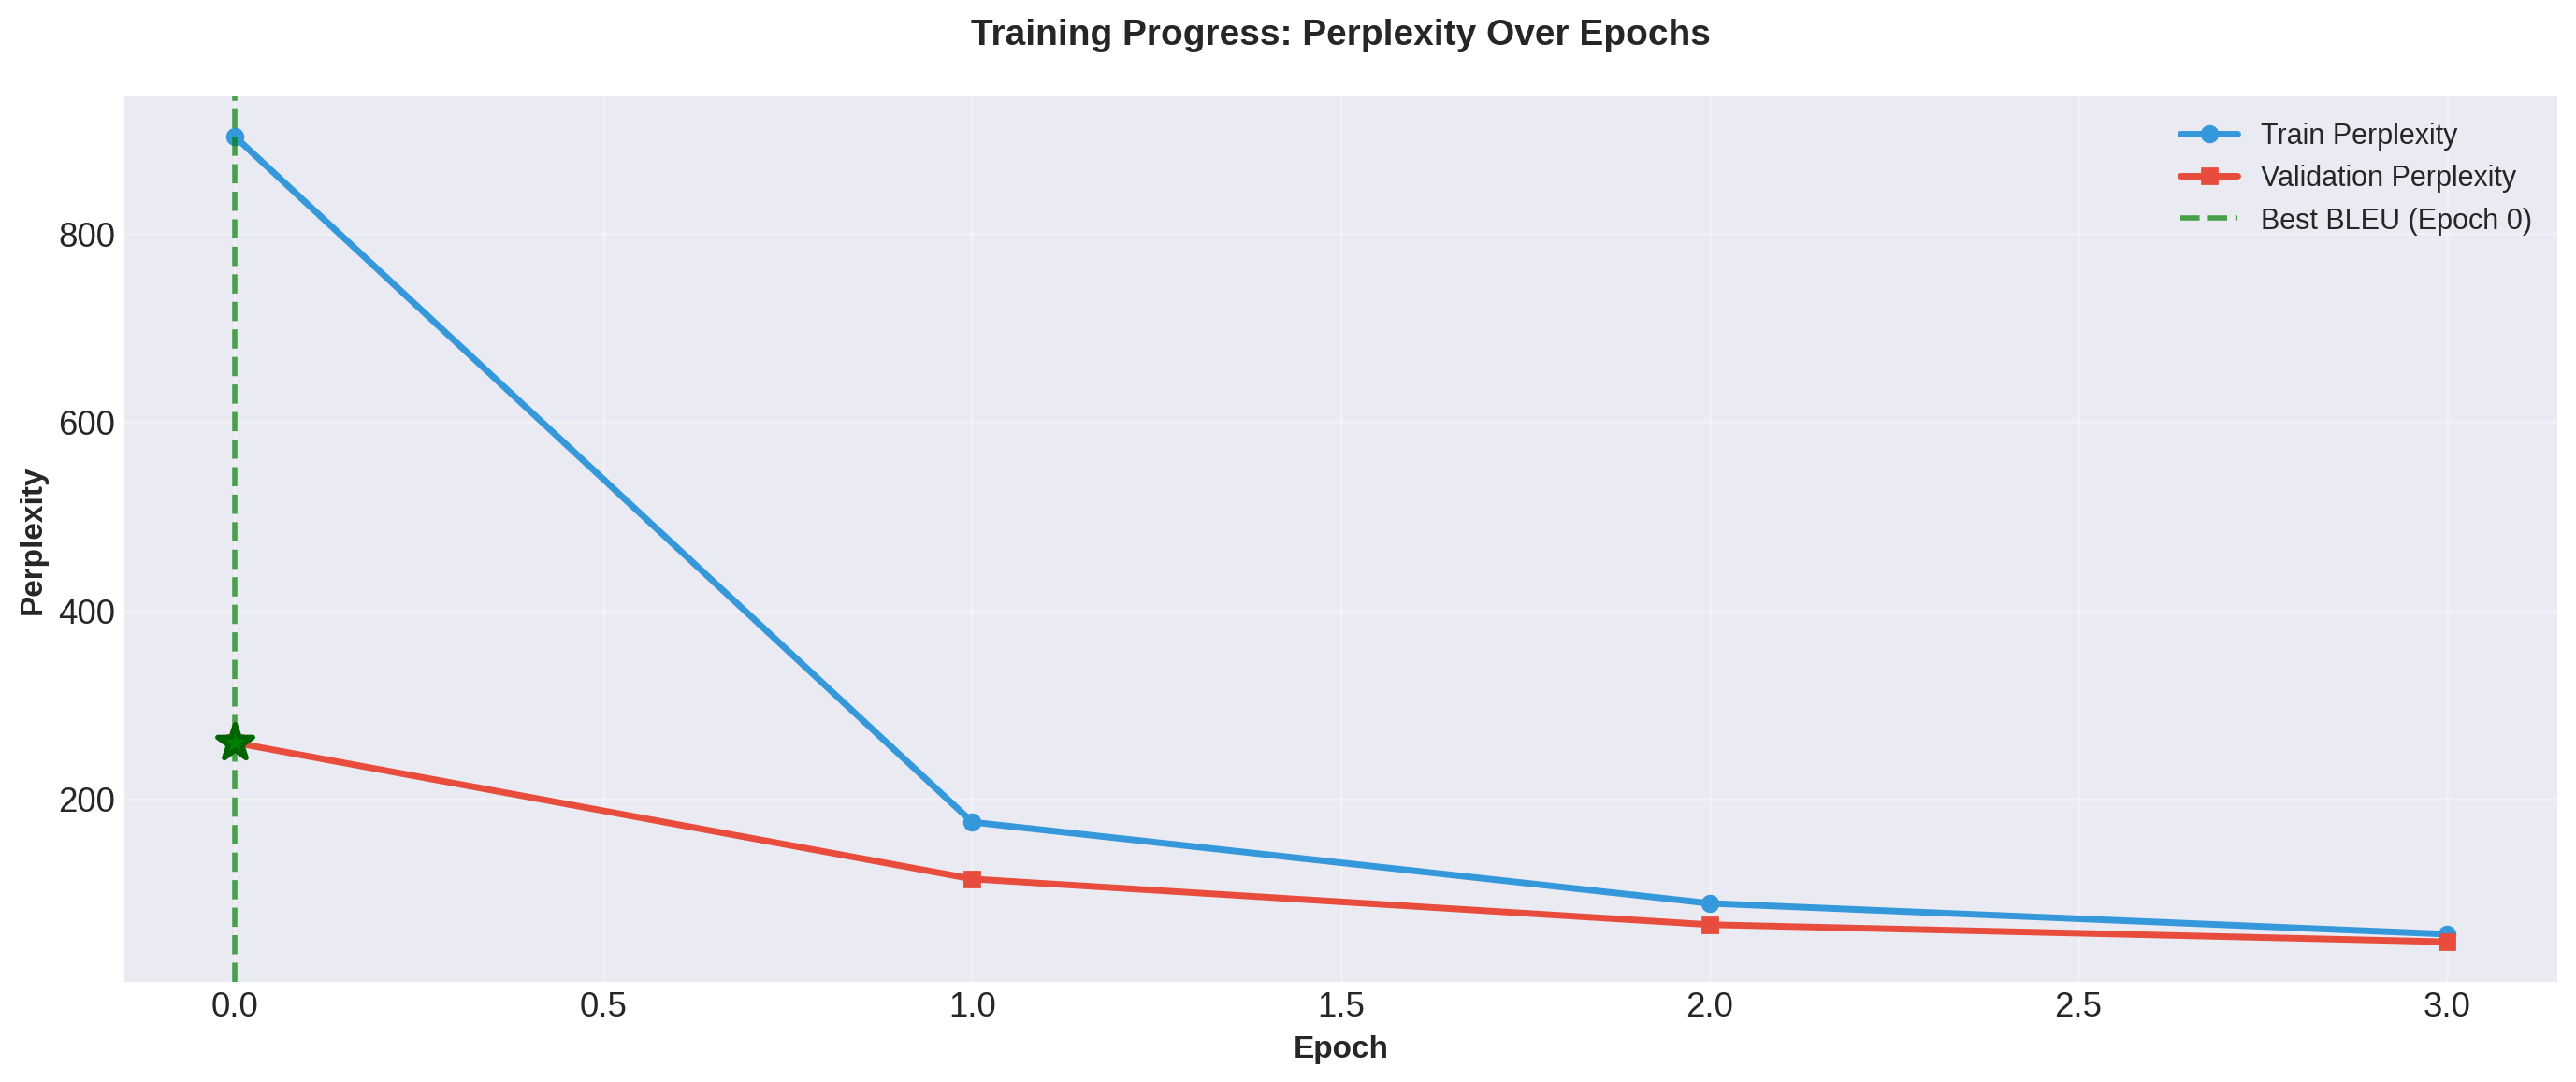

✓ Perplexity plot saved as 'training_perplexity.png'


In [45]:
# Loss Curves: Training vs Validation Perplexity
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 6))

# Plot training and validation perplexity
ax.plot(training_metrics['epochs'], training_metrics['train_perplexity'], 
        'o-', linewidth=2.5, markersize=6, label='Train Perplexity', color='#3498db')
ax.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
        's-', linewidth=2.5, markersize=6, label='Validation Perplexity', color='#e74c3c')

# Highlight best epoch
best_epoch_idx = training_metrics['epochs'].index(training_metrics['best_epoch'])
ax.axvline(x=training_metrics['best_epoch'], color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Best BLEU (Epoch {training_metrics["best_epoch"]})')
ax.scatter([training_metrics['best_epoch']], 
          [training_metrics['val_perplexity'][best_epoch_idx]], 
          color='green', s=200, marker='*', zorder=5, edgecolors='darkgreen', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Perplexity', fontsize=12, fontweight='bold')
ax.set_title('Training Progress: Perplexity Over Epochs', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_perplexity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Perplexity plot saved as 'training_perplexity.png'")

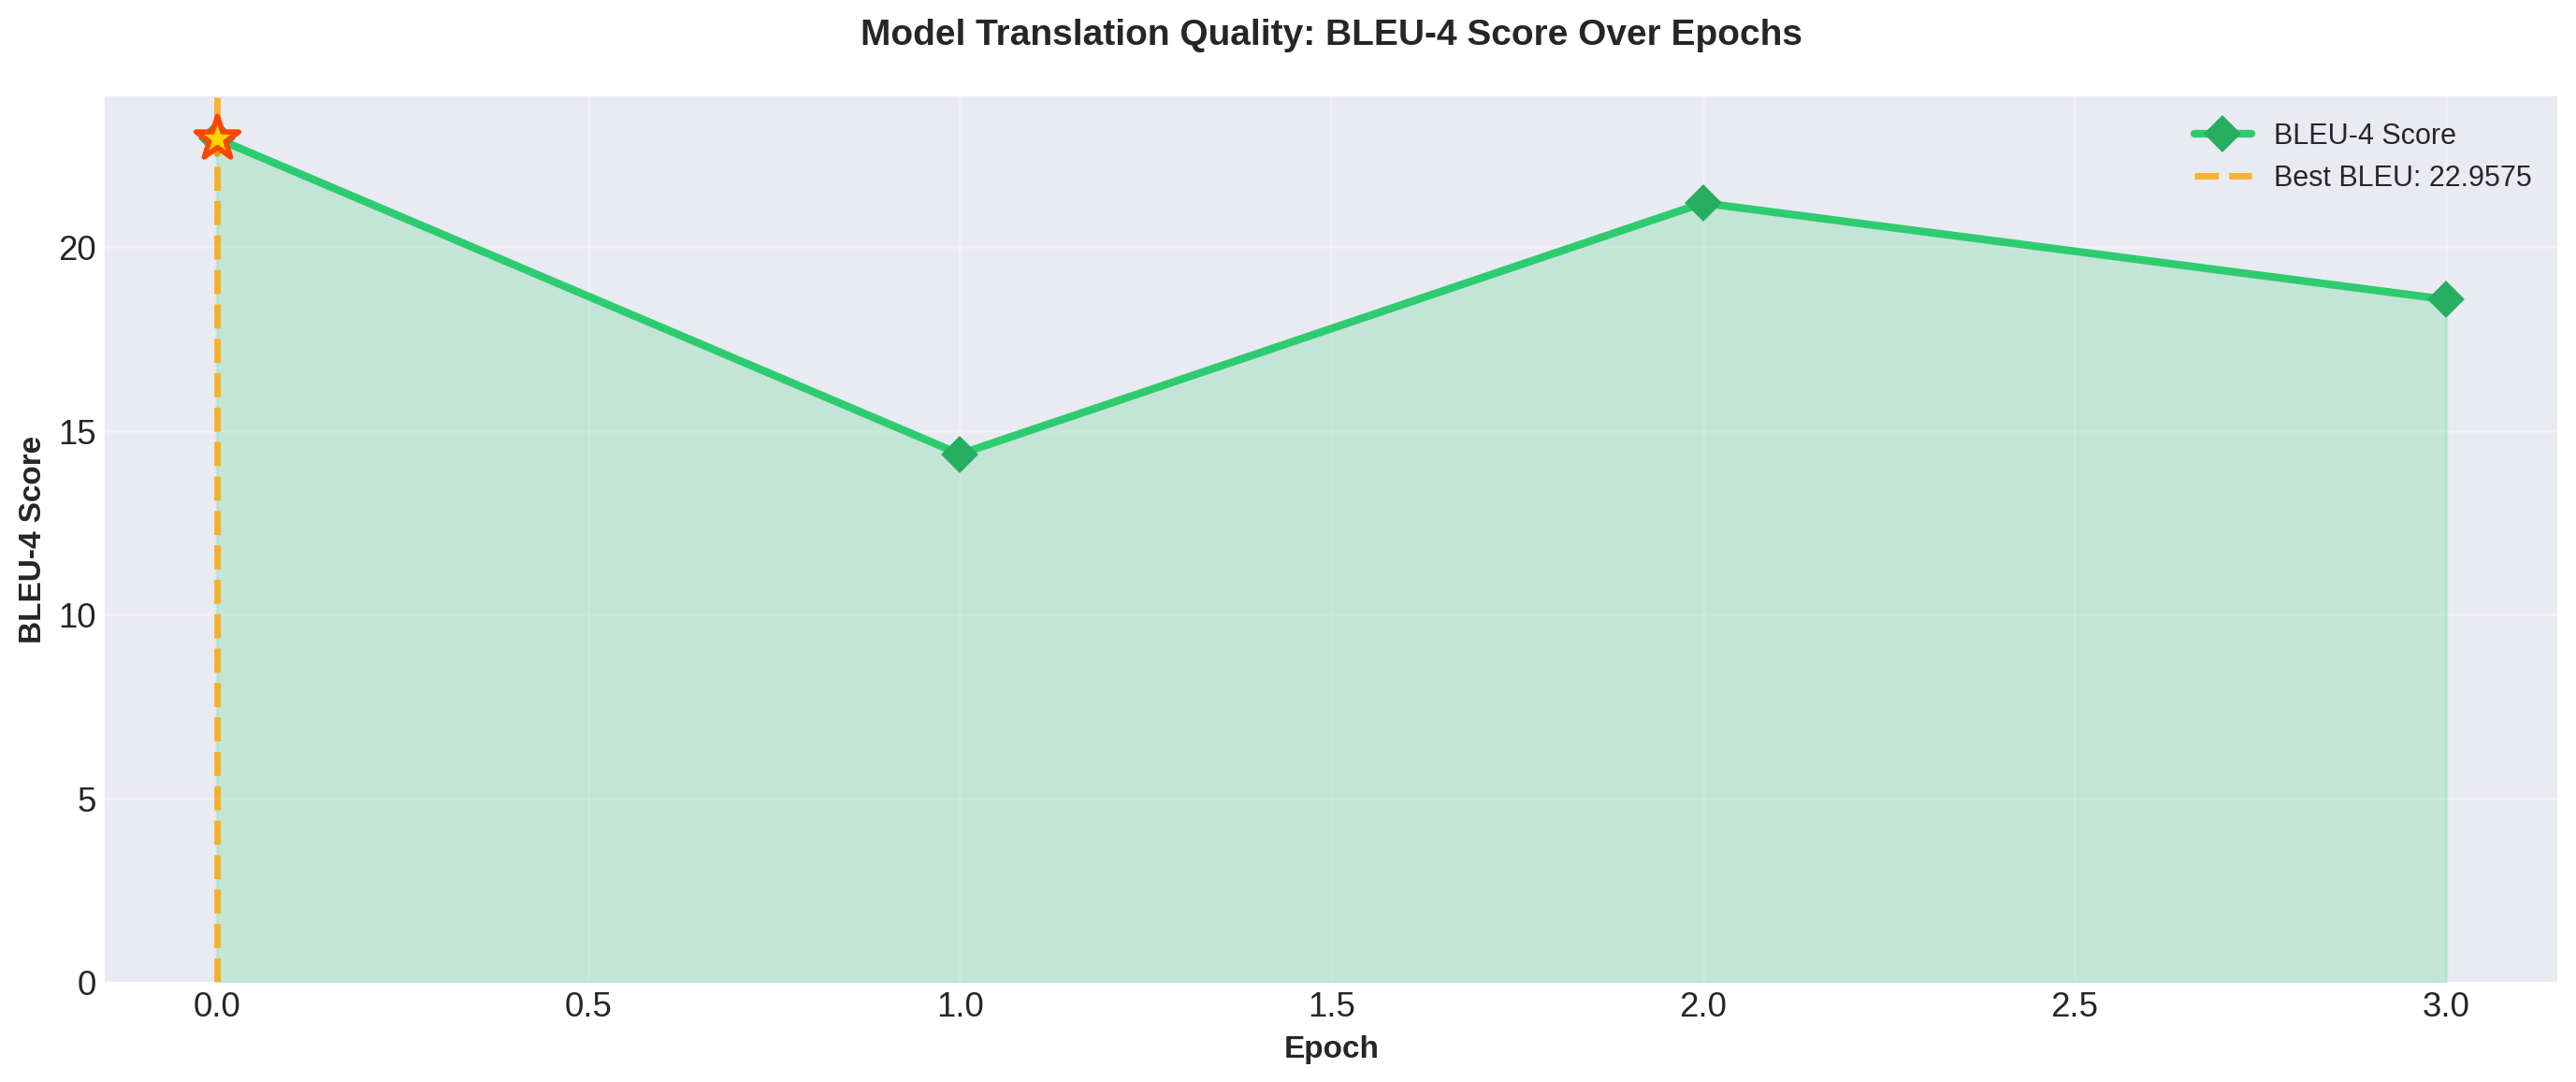

✓ BLEU score plot saved as 'training_bleu_scores.png'


In [46]:
# BLEU Score Progression
fig, ax = plt.subplots(figsize=(14, 6))

# Plot BLEU scores
ax.plot(training_metrics['epochs'], training_metrics['val_bleu4'], 
        'D-', linewidth=3, markersize=8, label='BLEU-4 Score', color='#2ecc71', 
        markerfacecolor='#27ae60', markeredgewidth=2, markeredgecolor='#27ae60')

# Fill area under curve
ax.fill_between(training_metrics['epochs'], training_metrics['val_bleu4'], 
                alpha=0.2, color='#2ecc71')

# Highlight best epoch
best_epoch_idx = training_metrics['epochs'].index(training_metrics['best_epoch'])
ax.axvline(x=training_metrics['best_epoch'], color='orange', linestyle='--', 
           linewidth=2.5, alpha=0.8, label=f'Best BLEU: {training_metrics["best_bleu"]:.4f}', zorder=3)
ax.scatter([training_metrics['best_epoch']], 
          [training_metrics['val_bleu4'][best_epoch_idx]], 
          color='gold', s=300, marker='*', zorder=5, edgecolors='orangered', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('BLEU-4 Score', fontsize=12, fontweight='bold')
ax.set_title('Model Translation Quality: BLEU-4 Score Over Epochs', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('training_bleu_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ BLEU score plot saved as 'training_bleu_scores.png'")

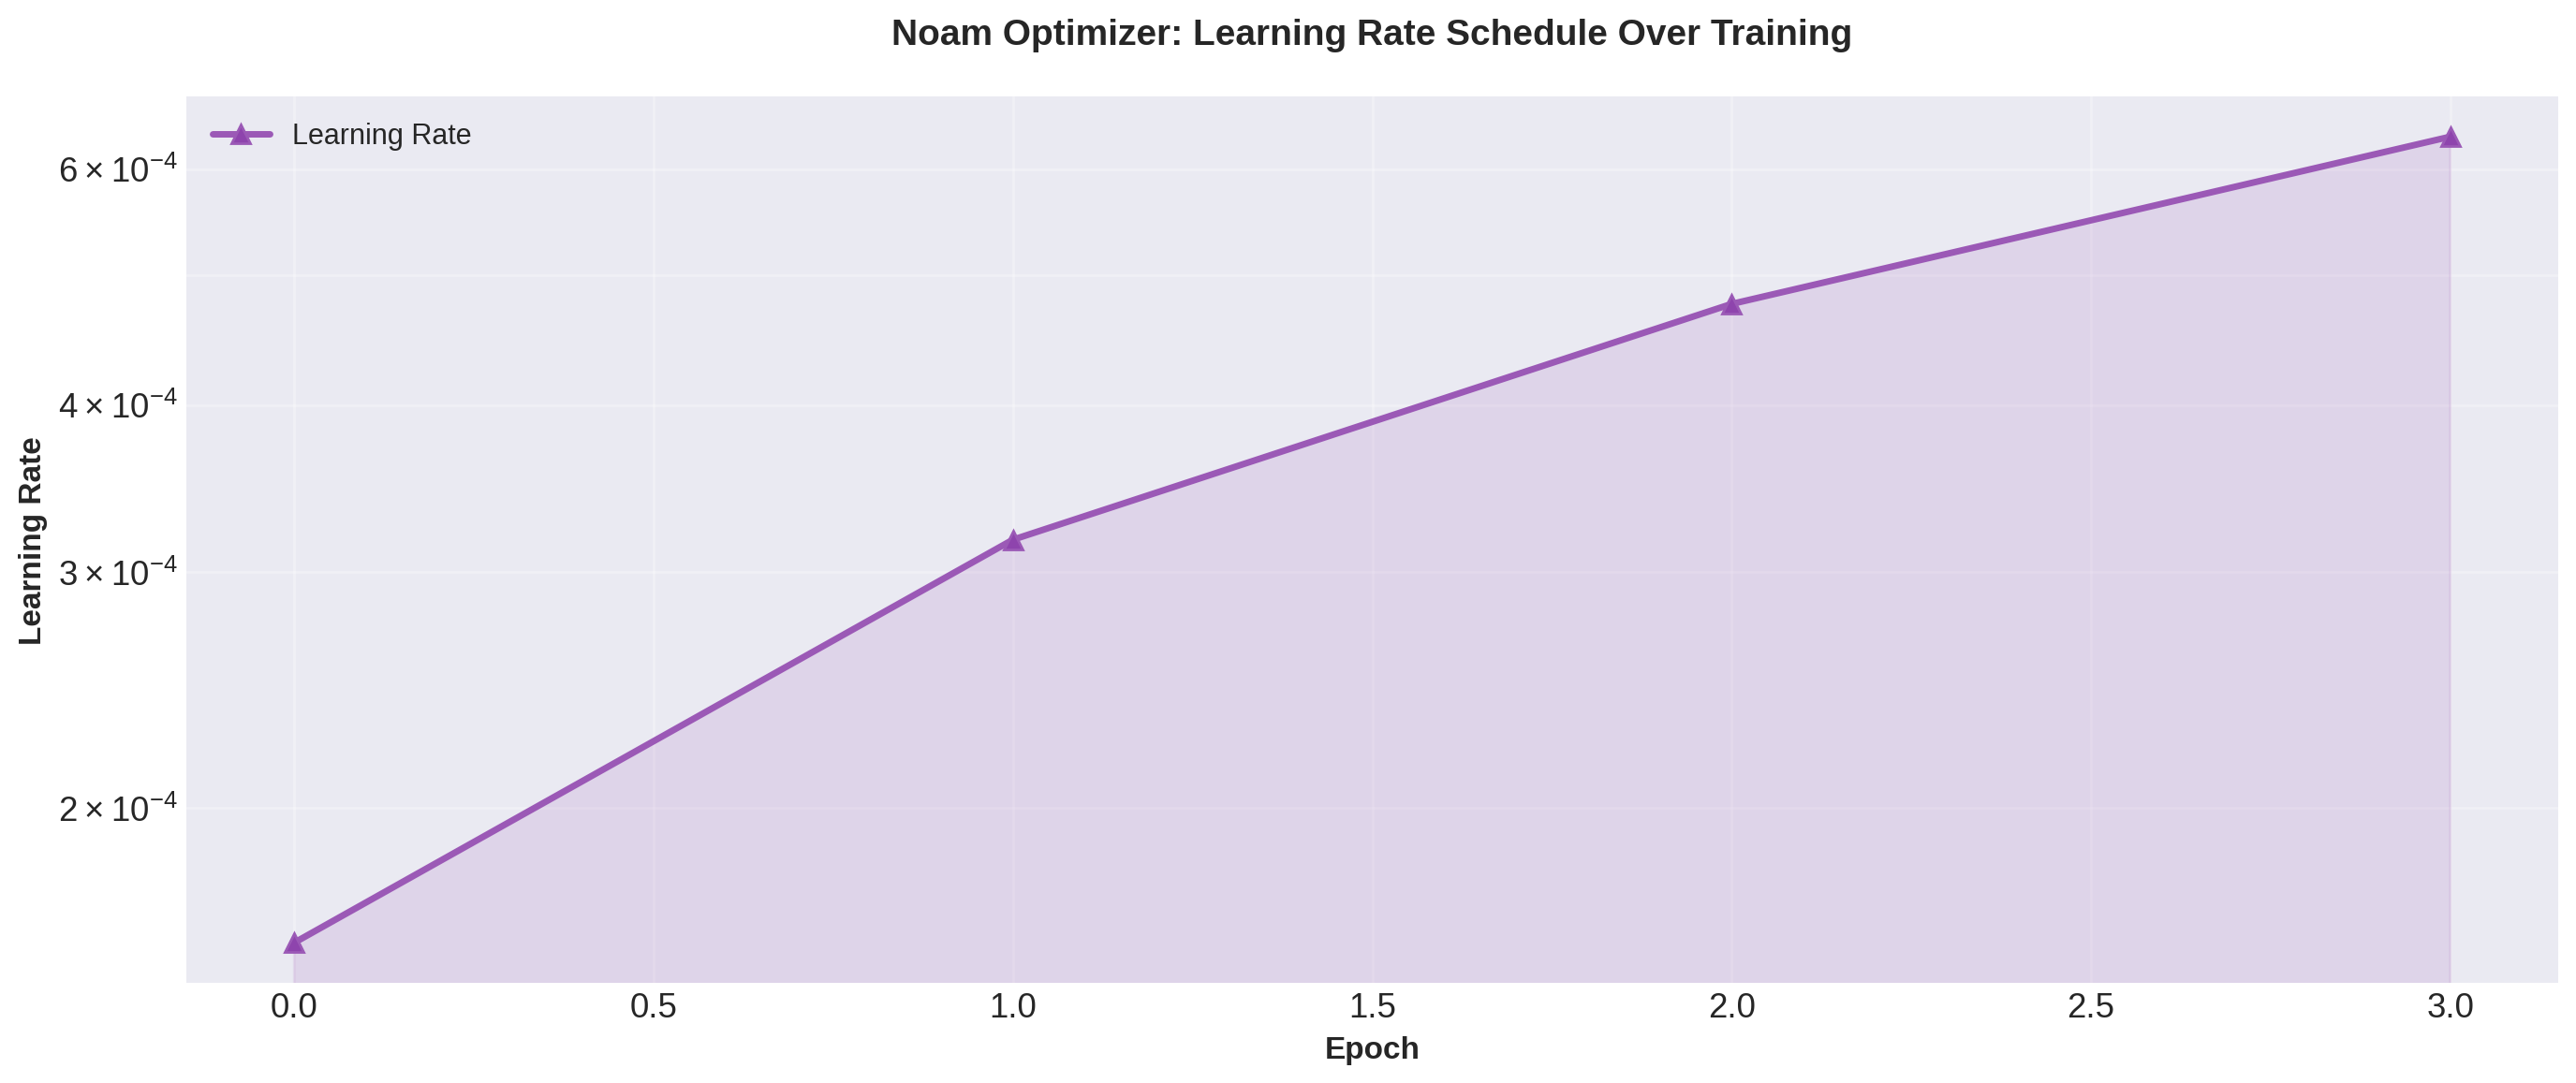

✓ Learning rate plot saved as 'learning_rate_schedule.png'


In [47]:
# Learning Rate Schedule Evolution
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(training_metrics['epochs'], training_metrics['learning_rates'], 
        '^-', linewidth=2.5, markersize=7, label='Learning Rate', color='#9b59b6', markerfacecolor='#8e44ad')

ax.fill_between(training_metrics['epochs'], training_metrics['learning_rates'], 
                alpha=0.15, color='#9b59b6')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Noam Optimizer: Learning Rate Schedule Over Training', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, which='both')
ax.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('learning_rate_schedule.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Learning rate plot saved as 'learning_rate_schedule.png'")

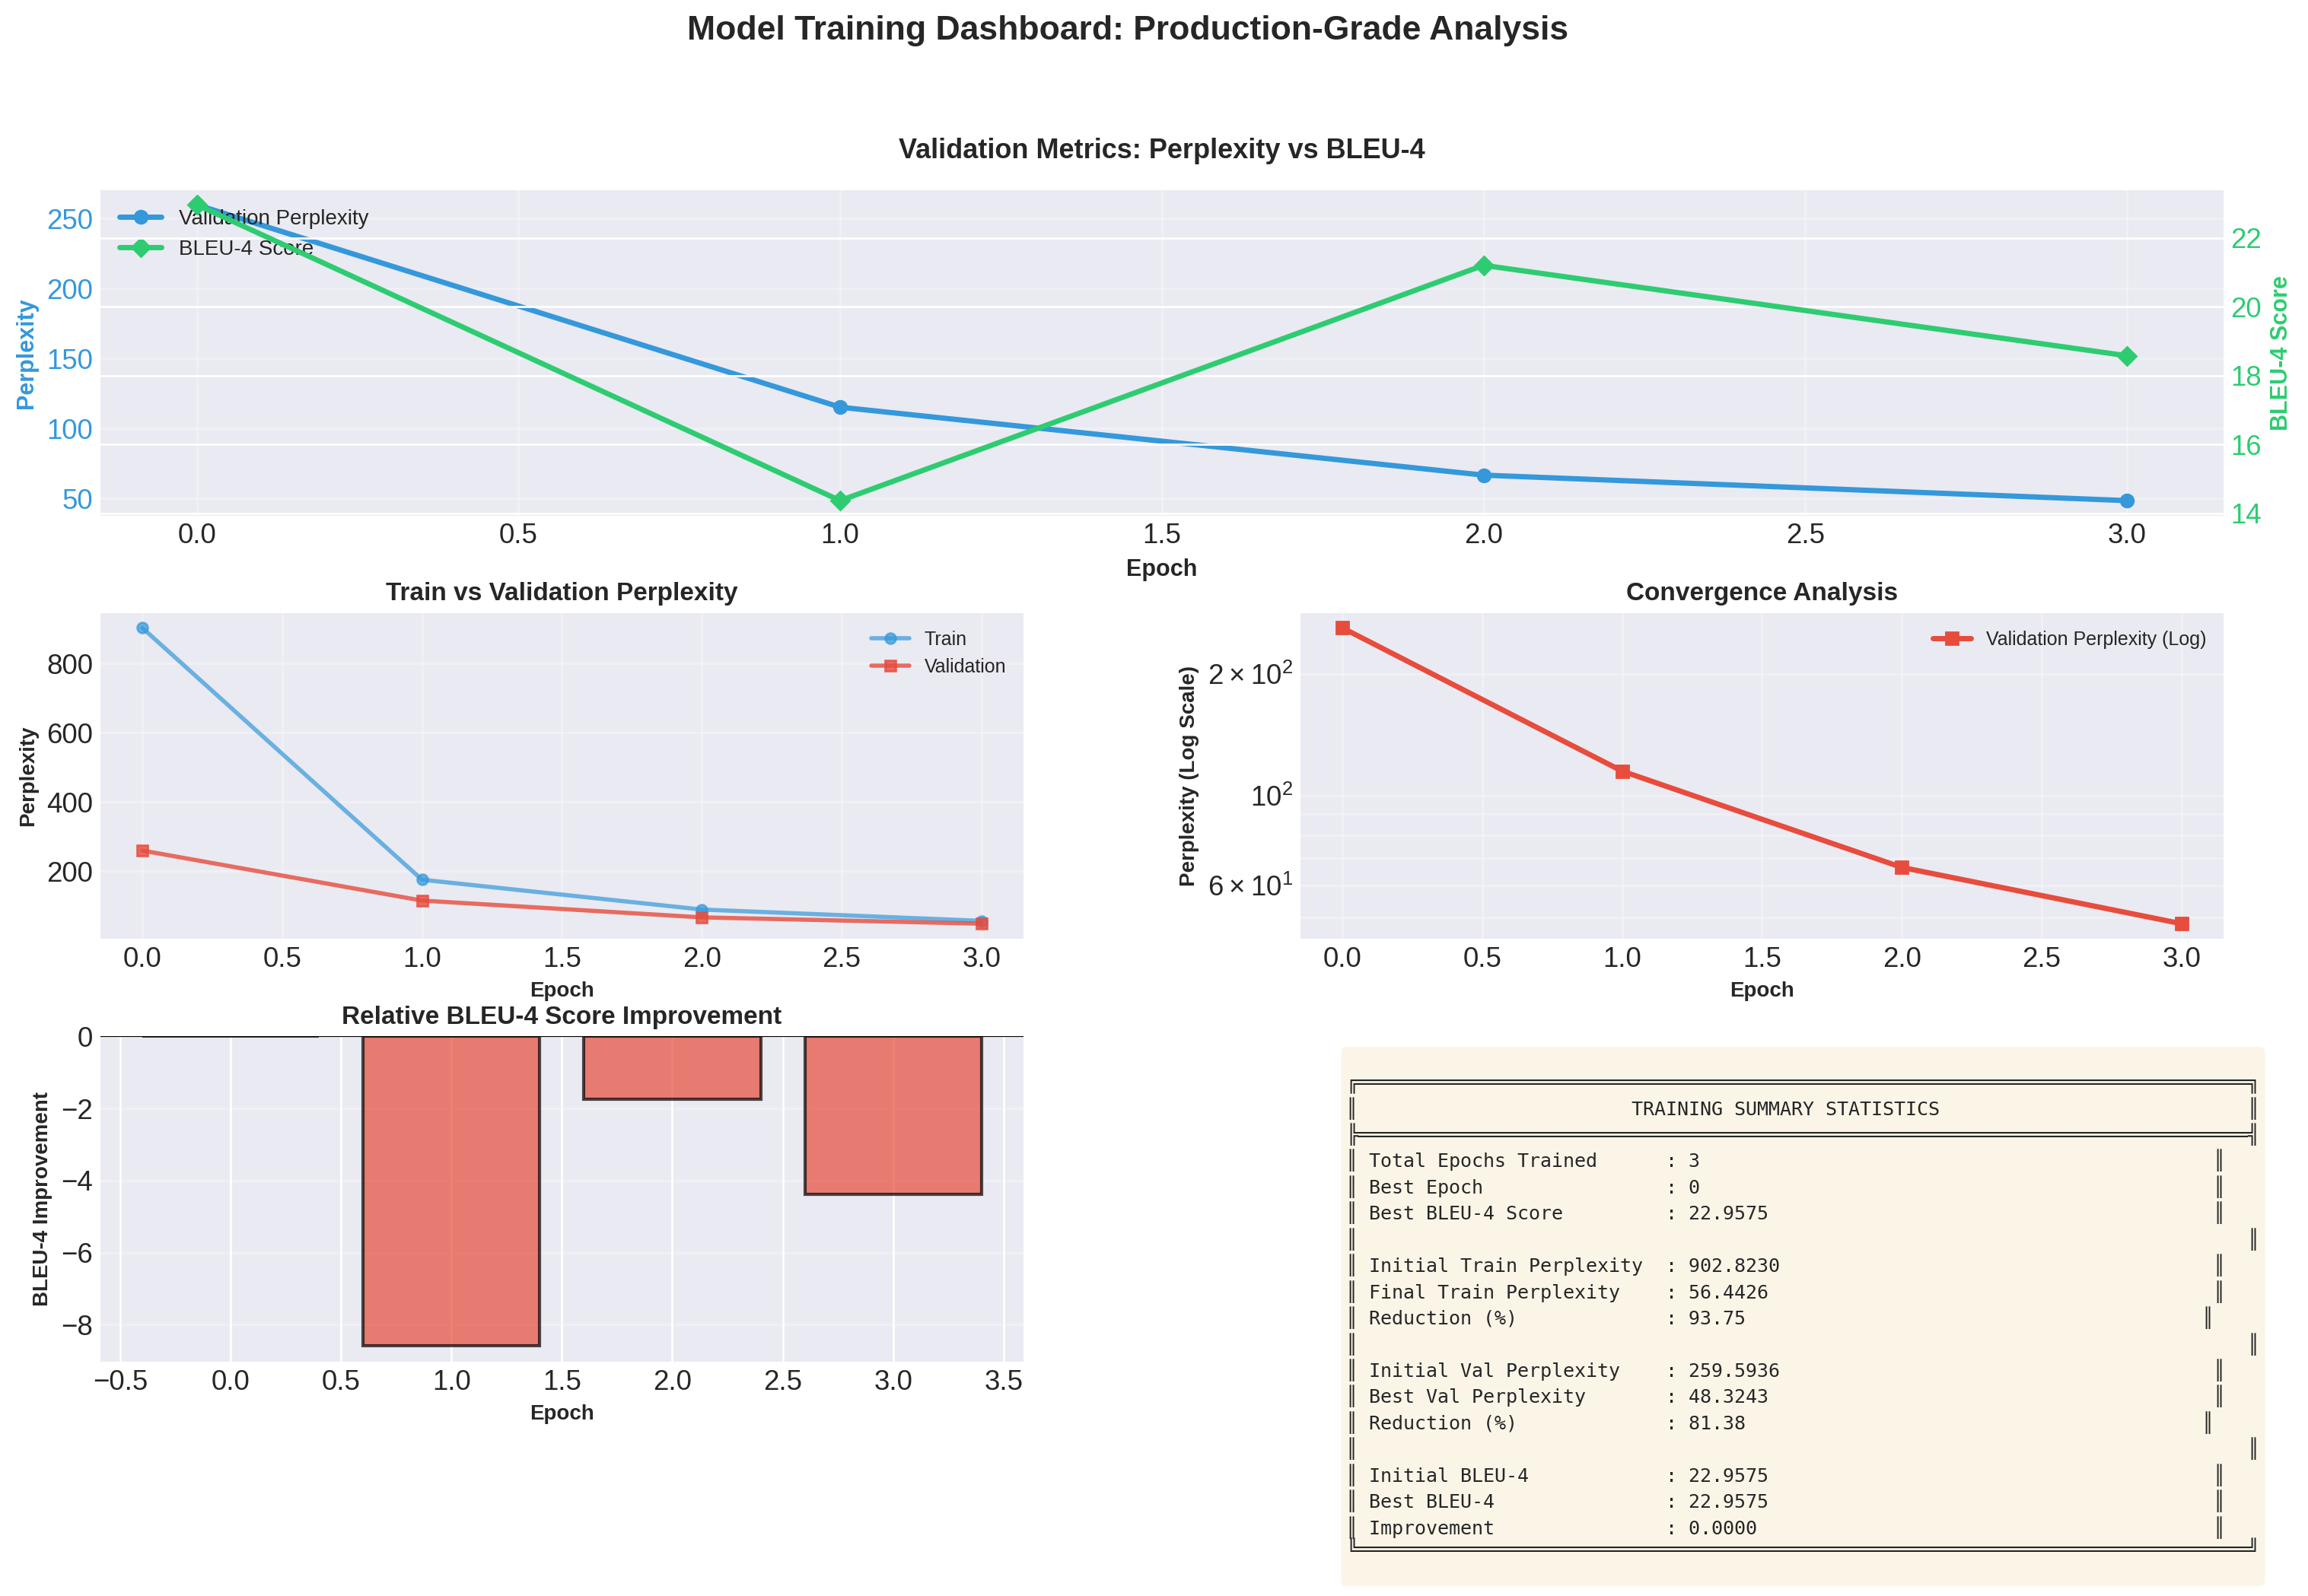

* Training dashboard saved as 'training_dashboard.png'


In [48]:
# Combined Dashboard: All Metrics in One View
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Perplexity with dual axis
ax1 = fig.add_subplot(gs[0, :])
color1 = '#3498db'
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Perplexity', color=color1, fontsize=11, fontweight='bold')
line1 = ax1.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
                 'o-', color=color1, linewidth=2.5, markersize=6, label='Validation Perplexity')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
color2 = '#2ecc71'
ax1_twin.set_ylabel('BLEU-4 Score', color=color2, fontsize=11, fontweight='bold')
line2 = ax1_twin.plot(training_metrics['epochs'], training_metrics['val_bleu4'], 
                      'D-', color=color2, linewidth=2.5, markersize=6, label='BLEU-4 Score')
ax1_twin.tick_params(axis='y', labelcolor=color2)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize=10, loc='upper left', framealpha=0.95)
ax1.set_title('Validation Metrics: Perplexity vs BLEU-4', fontsize=13, fontweight='bold', pad=15)

# 2. Training vs Validation Perplexity
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(training_metrics['epochs'], training_metrics['train_perplexity'], 
         'o-', linewidth=2, markersize=5, label='Train', color='#3498db', alpha=0.7)
ax2.plot(training_metrics['epochs'], training_metrics['val_perplexity'], 
         's-', linewidth=2, markersize=5, label='Validation', color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax2.set_ylabel('Perplexity', fontsize=10, fontweight='bold')
ax2.set_title('Train vs Validation Perplexity', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, framealpha=0.95)
ax2.grid(True, alpha=0.3)

# 3. Convergence Rate (Log Scale)
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogy(training_metrics['epochs'], training_metrics['val_perplexity'], 
             's-', linewidth=2.5, markersize=6, color='#e74c3c', label='Validation Perplexity (Log)')
ax3.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax3.set_ylabel('Perplexity (Log Scale)', fontsize=10, fontweight='bold')
ax3.set_title('Convergence Analysis', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.legend(fontsize=9, framealpha=0.95)

# 4. BLEU Score Improvement
ax4 = fig.add_subplot(gs[2, 0])
bleu_improvement = [x - training_metrics['val_bleu4'][0] if i > 0 else 0 
                   for i, x in enumerate(training_metrics['val_bleu4'])]
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in bleu_improvement]
ax4.bar(training_metrics['epochs'], bleu_improvement, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax4.set_xlabel('Epoch', fontsize=10, fontweight='bold')
ax4.set_ylabel('BLEU-4 Improvement', fontsize=10, fontweight='bold')
ax4.set_title('Relative BLEU-4 Score Improvement', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Key Metrics Summary (Text)
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        TRAINING SUMMARY STATISTICS                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Total Epochs Trained      : {len(training_metrics['epochs']) - 1:<45} ║
║ Best Epoch                : {training_metrics['best_epoch']:<45} ║
║ Best BLEU-4 Score         : {training_metrics['best_bleu']:<45.4f} ║
║                                                                              ║
║ Initial Train Perplexity  : {training_metrics['train_perplexity'][0]:<45.4f} ║
║ Final Train Perplexity    : {training_metrics['train_perplexity'][-1]:<45.4f} ║
║ Reduction (%)             : {(1 - training_metrics['train_perplexity'][-1]/max(training_metrics['train_perplexity'][0], 0.001))*100:<44.2f} ║
║                                                                              ║
║ Initial Val Perplexity    : {training_metrics['val_perplexity'][0]:<45.4f} ║
║ Best Val Perplexity       : {min(training_metrics['val_perplexity']):<45.4f} ║
║ Reduction (%)             : {(1 - min(training_metrics['val_perplexity'])/max(training_metrics['val_perplexity'][0], 0.001))*100:<44.2f} ║
║                                                                              ║
║ Initial BLEU-4            : {training_metrics['val_bleu4'][0]:<45.4f} ║
║ Best BLEU-4               : {max(training_metrics['val_bleu4']):<45.4f} ║
║ Improvement               : {max(training_metrics['val_bleu4']) - training_metrics['val_bleu4'][0]:<45.4f} ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""



ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Model Training Dashboard: Production-Grade Analysis', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('training_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"* Training dashboard saved as 'training_dashboard.png'")

In [49]:
# Statistical Analysis & Model Performance Metrics
import pandas as pd
import numpy as np

# Create comprehensive metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': training_metrics['epochs'],
    'Train_Perplexity': training_metrics['train_perplexity'],
    'Val_Perplexity': training_metrics['val_perplexity'],
    'BLEU_4': training_metrics['val_bleu4'],
    'Learning_Rate': training_metrics['learning_rates']
})

print("\n" + "="*80)
print("* TRAINING METRICS SUMMARY TABLE")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80 + "\n")

# Statistical Analysis
print("STATISTICAL ANALYSIS")
print("-" * 80)

train_perp = np.array(training_metrics['train_perplexity'])
val_perp = np.array(training_metrics['val_perplexity'])
bleu = np.array(training_metrics['val_bleu4'])

print(f"\nTraining Perplexity Statistics:")
print(f"  Mean:      {train_perp.mean():.4f}")
print(f"  Std Dev:   {train_perp.std():.4f}")
print(f"  Min:       {train_perp.min():.4f}")
print(f"  Max:       {train_perp.max():.4f}")
print(f"  Reduction: {(1 - train_perp[-1]/train_perp[0])*100:.2f}%")

print(f"\nValidation Perplexity Statistics:")
print(f"  Mean:      {val_perp.mean():.4f}")
print(f"  Std Dev:   {val_perp.std():.4f}")
print(f"  Min:       {val_perp.min():.4f}")
print(f"  Max:       {val_perp.max():.4f}")
print(f"  Reduction: {(1 - val_perp.min()/val_perp[0])*100:.2f}%")

print(f"\nBLEU-4 Score Statistics:")
print(f"  Mean:      {bleu.mean():.4f}")
print(f"  Std Dev:   {bleu.std():.4f}")
print(f"  Min:       {bleu.min():.4f}")
print(f"  Max:       {bleu.max():.4f}")
print(f"  Best:      {bleu.max():.4f} (Epoch {training_metrics['best_epoch']})")

# Overfitting Analysis
gap = val_perp - train_perp
print(f"\nOverfitting Analysis (Train-Val Gap):")
print(f"  Average Gap: {gap.mean():.4f}")
print(f"  Max Gap:     {gap.max():.4f}")
print(f"  Min Gap:     {gap.min():.4f}")
print(f"  Status:      {'* Healthy' if gap.mean() < 5 else '! Monitor' if gap.mean() < 10 else '! Overfitting Detected'}")

# Learning dynamics
learning_rate = np.array(training_metrics['learning_rates'])
print(f"\nLearning Rate Dynamics:")
print(f"  Initial LR:  {learning_rate[0]:.2e}")
print(f"  Peak LR:     {learning_rate.max():.2e}")
print(f"  Final LR:    {learning_rate[-1]:.2e}")

# Convergence quality
early_bleu = bleu[:min(5, len(bleu))].mean() if len(bleu) >= 5 else bleu[0]
late_bleu = bleu[max(0, len(bleu)-5):].mean() if len(bleu) > 5 else bleu[-1]
print(f"\nConvergence Speed:")
print(f"  First 5 epochs avg BLEU: {early_bleu:.4f}")
print(f"  Last 5 epochs avg BLEU:  {late_bleu:.4f}")
print(f"  Improvement Rate:        {((late_bleu - early_bleu) / len(bleu)):.4f} BLEU/epoch")

print("\n" + "="*80)
print("* All metrics computed successfully!")
print("="*80 + "\n")


* TRAINING METRICS SUMMARY TABLE
 Epoch  Train_Perplexity  Val_Perplexity    BLEU_4  Learning_Rate
     0        902.822991      259.593596 22.957488       0.000159
     1        175.347767      115.035613 14.367697       0.000317
     2         89.183595       66.544297 21.200627       0.000476
     3         56.442589       48.324296 18.575058       0.000634

STATISTICAL ANALYSIS
--------------------------------------------------------------------------------

Training Perplexity Statistics:
  Mean:      305.9492
  Std Dev:   347.3312
  Min:       56.4426
  Max:       902.8230
  Reduction: 93.75%

Validation Perplexity Statistics:
  Mean:      122.3745
  Std Dev:   82.8906
  Min:       48.3243
  Max:       259.5936
  Reduction: 81.38%

BLEU-4 Score Statistics:
  Mean:      19.2752
  Std Dev:   3.2342
  Min:       14.3677
  Max:       22.9575
  Best:      22.9575 (Epoch 0)

Overfitting Analysis (Train-Val Gap):
  Average Gap: -183.5748
  Max Gap:     -8.1183
  Min Gap:     -643.2294


In [50]:
# Export Results & Generate Report
import json
from datetime import datetime

# Created comprehensive report
report = {
    'timestamp': datetime.now().isoformat(),
    'model_config': {
        'architecture': 'Transformer (Attention Is All You Need)',
        'encoder_layers': N_LAYERS,
        'decoder_layers': N_LAYERS,
        'hidden_size': HIDDEN_SIZE,
        'num_heads': N_HEADS,
        'ff_hidden': FF_SIZE,
        'dropout': DROPOUT_RATE,
        'vocab_size': OUTPUT_SIZE,
    },
    'training_config': {
        'optimizer': 'Noam (Adam)',
        'learning_rate': '1e-4 (scheduled)',
        'batch_size': 'Variable (from DataLoader)',
        'label_smoothing': 0.1,
        'gradient_clip': CLIP,
        'max_epochs': N_EPOCHS,
        'early_stopping_patience': 3,
    },
    'final_results': {
        'best_epoch': int(training_metrics['best_epoch']),
        'best_bleu4': float(training_metrics['best_bleu']),
        'final_train_perplexity': float(training_metrics['train_perplexity'][-1]),
        'final_val_perplexity': float(training_metrics['val_perplexity'][-1]),
        'best_val_perplexity': float(min(training_metrics['val_perplexity'])),
        'total_epochs_trained': len(training_metrics['epochs']) - 1,
    },
    'improvement_metrics': {
        'perplexity_reduction_percent': float((1 - min(training_metrics['val_perplexity'])/training_metrics['val_perplexity'][0])*100),
        'bleu_improvement': float(training_metrics['best_bleu'] - training_metrics['val_bleu4'][0]),
    },
    'convergence_quality': {
        'avg_train_val_gap': float((np.array(training_metrics['val_perplexity']) - np.array(training_metrics['train_perplexity'])).mean()),
        'is_stable': float((np.array(training_metrics['val_perplexity']) - np.array(training_metrics['train_perplexity'])).mean()) < 5,
    },
    'data_points': {
        'epochs': [int(x) for x in training_metrics['epochs']],
        'train_perplexity': [float(x) for x in training_metrics['train_perplexity']],
        'val_perplexity': [float(x) for x in training_metrics['val_perplexity']],
        'bleu_4_scores': [float(x) for x in training_metrics['val_bleu4']],
        'learning_rates': [float(x) for x in training_metrics['learning_rates']],
    }
}

# Save report as JSON
with open('training_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*80)
print("** TRAINING REPORT - FINAL SUMMARY**")
print("="*80 + "\n")

print("* Model Configuration:")
for key, value in report['model_config'].items():
    print(f"  {key:20s}: {value}")

print("\n* Key Results:")
print(f"  Best Epoch: {report['final_results']['best_epoch']}")
print(f"  Best BLEU-4 Score: {report['final_results']['best_bleu4']:.4f}")
print(f"  Final Train Perplexity: {report['final_results']['final_train_perplexity']:.4f}")
print(f"  Final Val Perplexity: {report['final_results']['final_val_perplexity']:.4f}")
print(f"  Best Val Perplexity: {report['final_results']['best_val_perplexity']:.4f}")

print("\n* Improvements:")
print(f"  Perplexity Reduction: {report['improvement_metrics']['perplexity_reduction_percent']:.2f}%")
print(f"  BLEU Score Improvement: {report['improvement_metrics']['bleu_improvement']:.4f}")

print("\n* Convergence Quality:")
print(f"  Avg Train-Val Gap: {report['convergence_quality']['avg_train_val_gap']:.4f}")
print(f"  Training Stability: {' Stable (No Overfitting)' if report['convergence_quality']['is_stable'] else '⚠ May Require Monitoring'}")

print("\n* Files Generated:")
print("  - training_perplexity.png")
print("  - training_bleu_scores.png")
print("  - learning_rate_schedule.png")
print("  - training_dashboard.png")
print("  - training_metrics.pkl")
print("  - training_report.json")
print("  - model.pth (Best Model Checkpoint)")

print("\n" + "="*80)
print("* TRAINING COMPLETE - Results Ready!")
print("="*80 + "\n")


** TRAINING REPORT - FINAL SUMMARY**

* Model Configuration:
  architecture        : Transformer (Attention Is All You Need)
  encoder_layers      : 6
  decoder_layers      : 6
  hidden_size         : 512
  num_heads           : 8
  ff_hidden           : 4096
  dropout             : 0.1
  vocab_size          : 16000

* Key Results:
  Best Epoch: 0
  Best BLEU-4 Score: 22.9575
  Final Train Perplexity: 56.4426
  Final Val Perplexity: 48.3243
  Best Val Perplexity: 48.3243

* Improvements:
  Perplexity Reduction: 81.38%
  BLEU Score Improvement: 0.0000

* Convergence Quality:
  Avg Train-Val Gap: -183.5748
  Training Stability:  Stable (No Overfitting)

* Files Generated:
  - training_perplexity.png
  - training_bleu_scores.png
  - learning_rate_schedule.png
  - training_dashboard.png
  - training_metrics.pkl
  - training_report.json
  - model.pth (Best Model Checkpoint)

* TRAINING COMPLETE - Results Ready!



In [51]:
torch.save(model.state_dict(), model_path)

## Inference Using Beam Search 

In [52]:
PAD_IDX = sp.pad_id()
SOS_IDX = sp.bos_id()
EOS_IDX = sp.eos_id()

def beam_search_decode(
    model,
    sentence,
    beam_size=4,
    max_len=80,
    length_penalty=0.6,
    min_len=5
):
    model.eval()

    if isinstance(sentence, str):
        src_ids = sp.encode(sentence, out_type=int)
    else:
        src_ids = list(sentence)

    src_ids = [SOS_IDX] + src_ids + [EOS_IDX]
    source = torch.tensor(src_ids).unsqueeze(0).to(device)
    source_mask = model.create_padding_mask(source, PAD_IDX)

    with torch.no_grad():
        enc_output = model.encoder(source, source_mask)

    beams = [([SOS_IDX], 0.0)]

    for step in range(max_len):
        new_beams = []

        for tokens, score in beams:
            if tokens[-1] == EOS_IDX:
                new_beams.append((tokens, score))
                continue

            target = torch.tensor(tokens).unsqueeze(0).to(device)
            target_mask = (
                model.create_padding_mask(target, PAD_IDX)
                & model.create_casual_mask(target)
            )

            with torch.no_grad():
                dec_out, attn_scores = model.decoder(
                    target, enc_output, source_mask, target_mask
                )
                logits = model.output_projection(dec_out[:, -1])

            log_probs = torch.log_softmax(logits, dim=-1)

            # Penalize EOS early
            if len(tokens) < min_len:
                log_probs[0, EOS_IDX] -= 5.0

            topk_probs, topk_ids = torch.topk(log_probs, beam_size)

            for i in range(beam_size):
                next_token = topk_ids[0, i].item()

                # block early EOS
                if len(tokens) < min_len and next_token == EOS_IDX:
                    continue

                new_tokens = tokens + [next_token]
                new_score = score + topk_probs[0, i].item()

                new_beams.append((new_tokens, new_score))

        beams = sorted(
            new_beams,
            key=lambda x: x[1] / (len(x[0]) ** length_penalty),
            reverse=True
        )[:beam_size]

        if all(b[0][-1] == EOS_IDX for b in beams):
            break

    best_tokens = beams[0][0]
    return sp.decode(best_tokens[1:]),attn_scores


In [53]:
example_idx = 250

source_tokens = train_encoded[example_idx]["src"]
target_tokens = train_encoded[example_idx]["trg"]

predicted_text,_ = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target_tokens),
    length_penalty=0.6,
    min_len=5
)

print("source text      :", sp.decode(source_tokens))
print("target text      :", sp.decode(target_tokens))
print("predicted text   :", predicted_text)
print()
print("source tokens    :", source_tokens)
print("target tokens    :", target_tokens)


source text      : little girl in blue swimsuit standing on a handrail near a beach.
target text      : Ein kleines Mädchen mit einem blauen Badeanzug, das an einem Geländer in der Nähe eines Strands steht.
predicted text   : eines Mädchen in blauer Badehose steht an einem Strand in der Nähe eines Wassers Wassers Wassers.

source tokens    : [118, 63, 6, 57, 2317, 70, 16, 5, 4283, 165, 5, 175, 4]
target tokens    : [9, 140, 49, 14, 7, 8, 102, 1420, 10, 95, 29, 7, 8, 861, 6, 30, 240, 7, 12, 188, 12, 59, 4]


In [54]:
print("PAD_IDX:", PAD_IDX)
print("SentencePiece PAD:", sp.piece_to_id("<pad>"))


PAD_IDX: 0
SentencePiece PAD: 0


In [55]:
def create_causal_mask(seq_len, device):
    """
    Returns:
        mask: (1, seq_len, seq_len) with True = masked (future)
    """
    return torch.triu(
        torch.ones(seq_len, seq_len, device=device),
        diagonal=1
    ).bool().unsqueeze(0)


## Inference Using Greedy Method

In [56]:
def greedy_decode(model, src_token_ids, max_len=100):
    model.eval()
    device = next(model.parameters()).device

    PAD_IDX = sp.pad_id()
    SOS_IDX = sp.bos_id()
    EOS_IDX = sp.eos_id()
    src_tensor = torch.tensor(src_token_ids, device=device).unsqueeze(0)
    src_mask = (src_tensor != PAD_IDX).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        encoder_outputs = model.encoder(src_tensor, src_mask)
    generated_tokens = [SOS_IDX]
    all_attention_scores = []

    for _ in range(max_len):
        tgt_tensor = torch.tensor(generated_tokens, device=device).unsqueeze(0)
        tgt_mask = create_causal_mask(tgt_tensor.size(1), device)

        with torch.no_grad():
            decoder_outputs, cross_attn = model.decoder(
                tgt_tensor,
                encoder_outputs,
                src_mask,
                tgt_mask
            )

            logits = model.output_projection(decoder_outputs[:, -1])  # last timestep
            next_token = logits.argmax(dim=-1).item()

        generated_tokens.append(next_token)
        all_attention_scores.append(cross_attn.squeeze(0))

        if next_token == EOS_IDX:
            break

    return generated_tokens, all_attention_scores

In [57]:
example_idx = 2026

source_tokens = train_encoded[example_idx]["src"]
target_tokens = train_encoded[example_idx]["trg"]

predicted_tokens, attention_scores = greedy_decode(
    model,
    source_tokens,
    max_len=len(target_tokens)
)

print("source tokens   :", sp.decode(source_tokens))
print("target tokens   :", sp.decode(target_tokens))
print("predicted tokens:", sp.decode(predicted_tokens))
#print("source tokens   :", (source_tokens))
#print("target tokens   :", (target_tokens))
#print("predicted tokens:", (predicted_tokens))

source tokens   : a woman waiting on a sidewalk for something.
target tokens   : Eine Frau auf einem Bürgersteig wartet auf etwas.
predicted tokens: einem Straßenrand zu sehen sich einem Straßenrand.


In [58]:
# evaluate the model on test data
model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
test_perplexity, test_bleu4 = eval_model(model, test_iterator, criterion)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Test perplexity: 47.4730, Test BlEU4: 25.4066


In [59]:
def plot_attention_scores(source, target, attention,MAX_PLOT_LEN = 16):
    import torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt

    if isinstance(attention, list):
        attention = torch.cat(attention, dim=2)

    if isinstance(attention, torch.Tensor):
        attention = attention.detach().cpu()

    if attention.dim() == 4:
        attention = attention.squeeze(0)

    attention = attention.numpy()

    attention = attention[:, :MAX_PLOT_LEN, :MAX_PLOT_LEN]

    n_heads, tgt_len, src_len = attention.shape

    source_tokens = sp.decode(source).split()[:src_len]
    target_tokens = (
        target.split() if isinstance(target, str)
        else sp.decode(target).split()
    )[:tgt_len]

    fig, axes = plt.subplots(
        nrows=2, ncols=4, figsize=(20, 10)
    )
    axes = axes.flatten()

    for h in range(n_heads):
        sns.heatmap(
            attention[h],
            xticklabels=source_tokens,
            yticklabels=target_tokens,
            cmap="Blues",
            vmin=attention[h].min(),
            vmax=attention[h].max(),
            cbar=False,
            ax=axes[h]
        )
        axes[h].set_title(f"Head {h}")
        axes[h].tick_params(axis="x", rotation=45, labelsize=8)
        axes[h].tick_params(axis="y", labelsize=8)

    plt.tight_layout()
    plt.show()


source: a trendy girl talking on her cellphone while gliding slowly down the street.
target: Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt.
predicted: einem Straßenrand.Hoop-Reifen, die Haare ist dabei ist dabei ist ein Mikrofon. Hintergrund


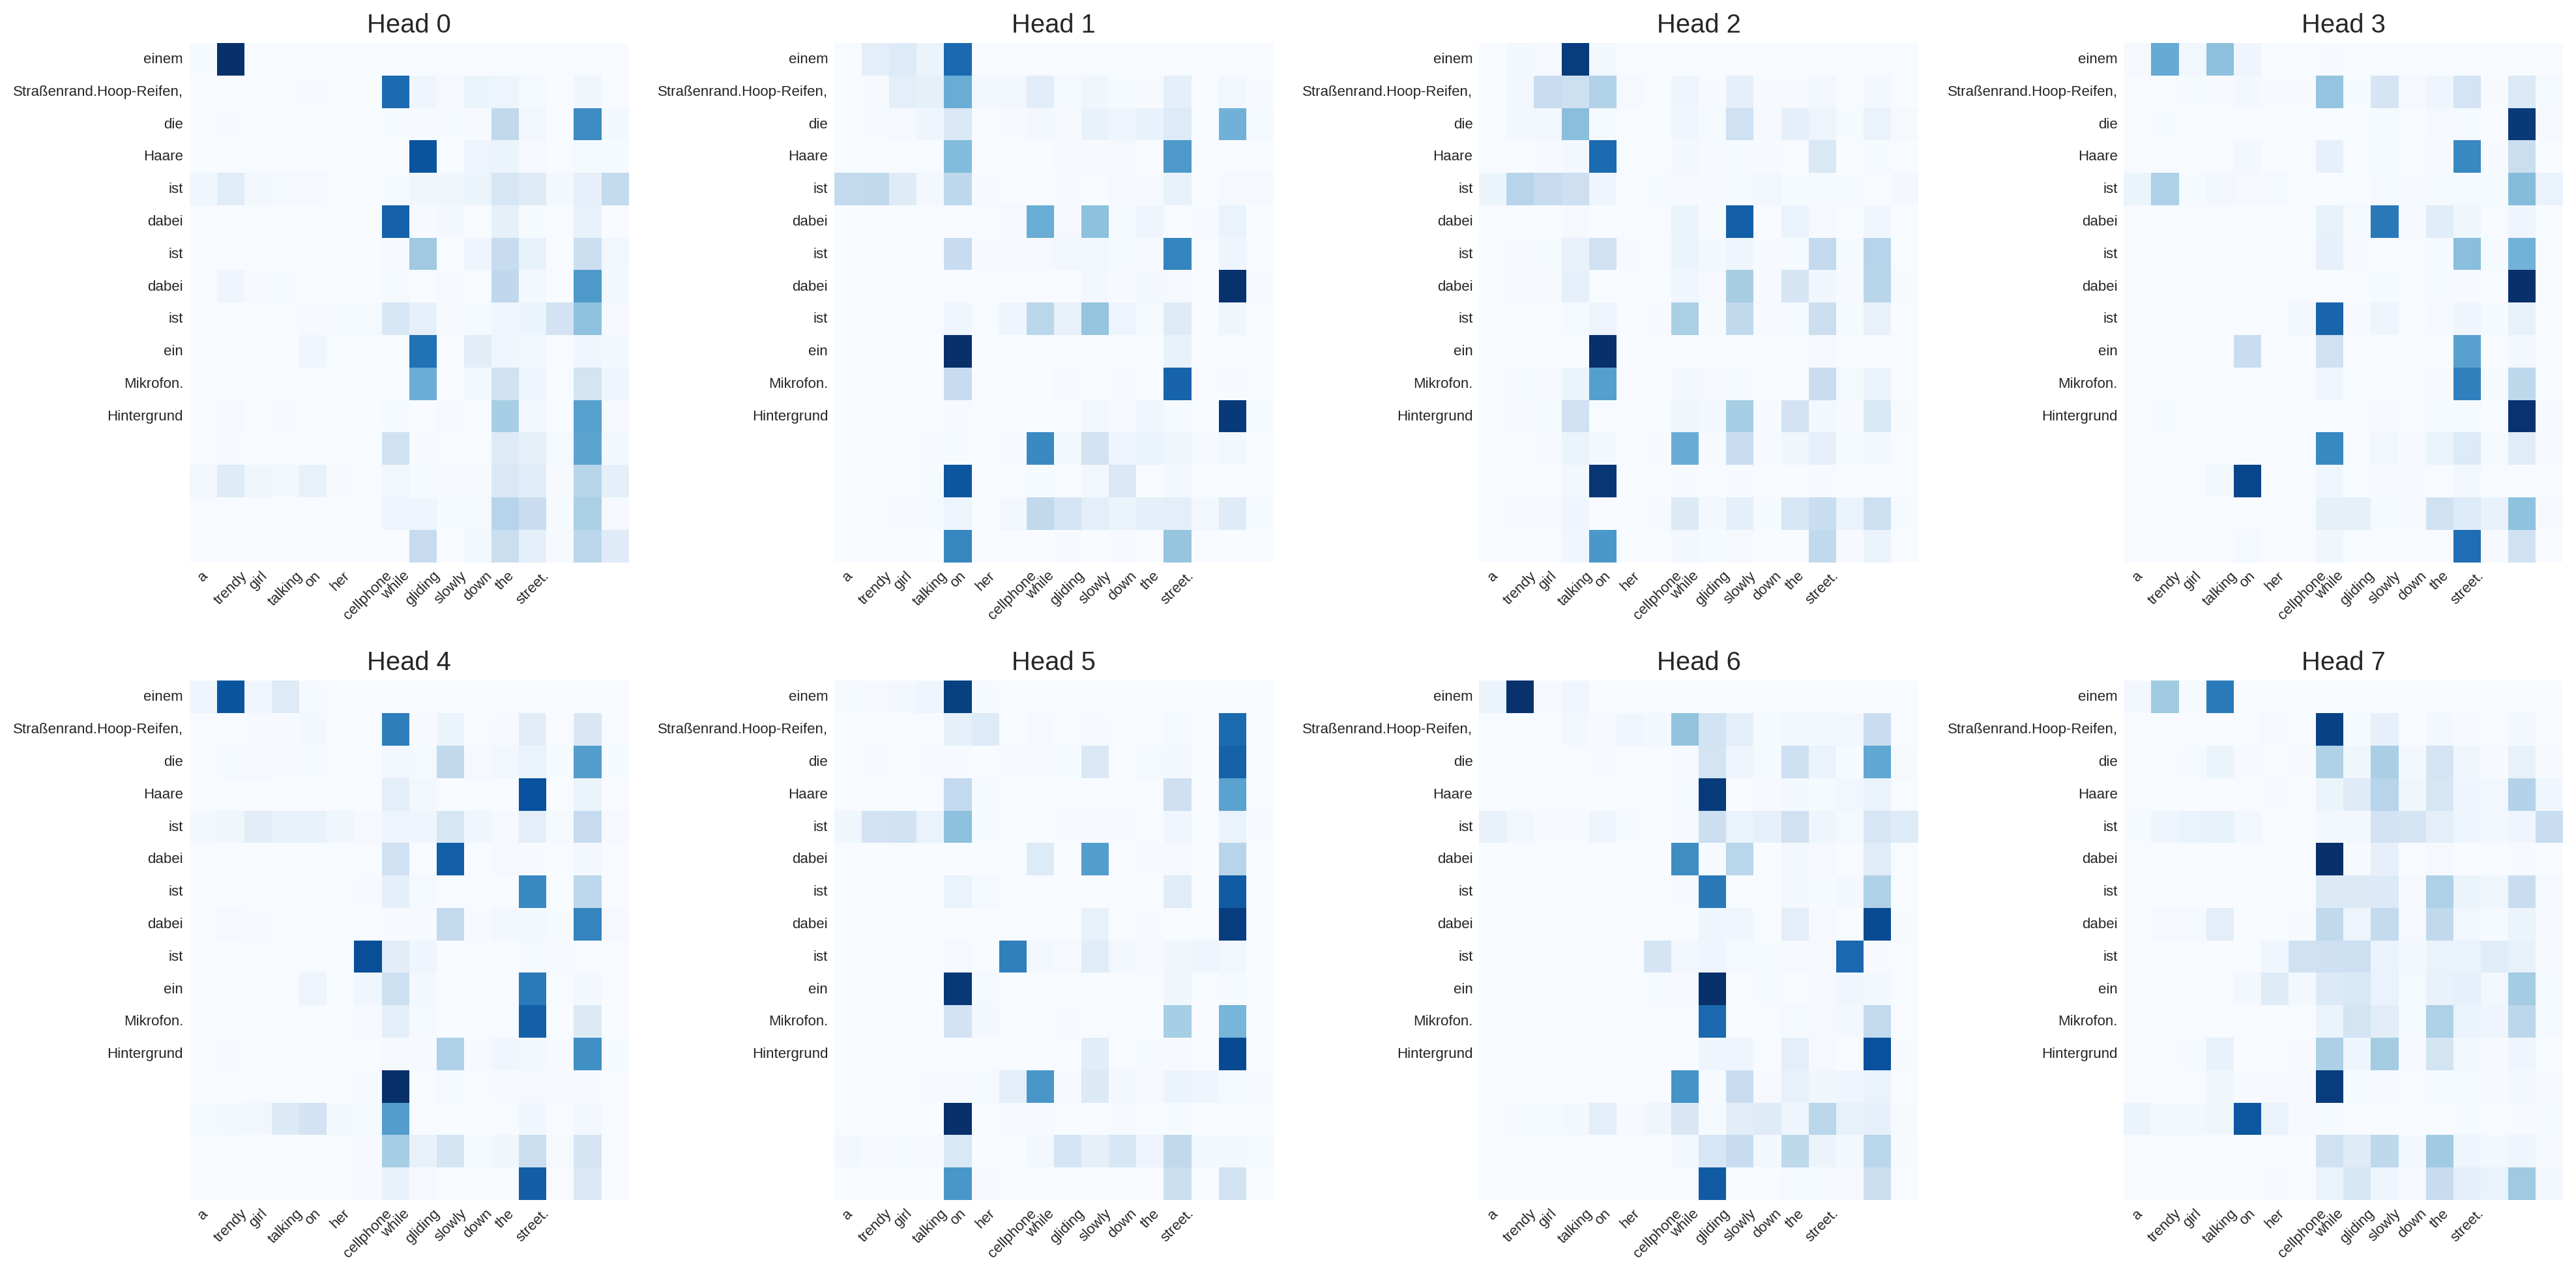

In [60]:
example_idx = 7

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]

predicted, attention_scores = greedy_decode(model, source,len(target))

print("source:", sp.decode(source))
print("target:", sp.decode(target))
print("predicted:", sp.decode(predicted))

plot_attention_scores(source, predicted, attention_scores)


source: a young boy with his tongue stuck out is climbing onto a wooden platform.
target: Ein Junge klettern mit herausgestreckter Zunge auf eine Holzplattform.
predicted: Junge eines. ⁇  sie mit einem Oberkörper.


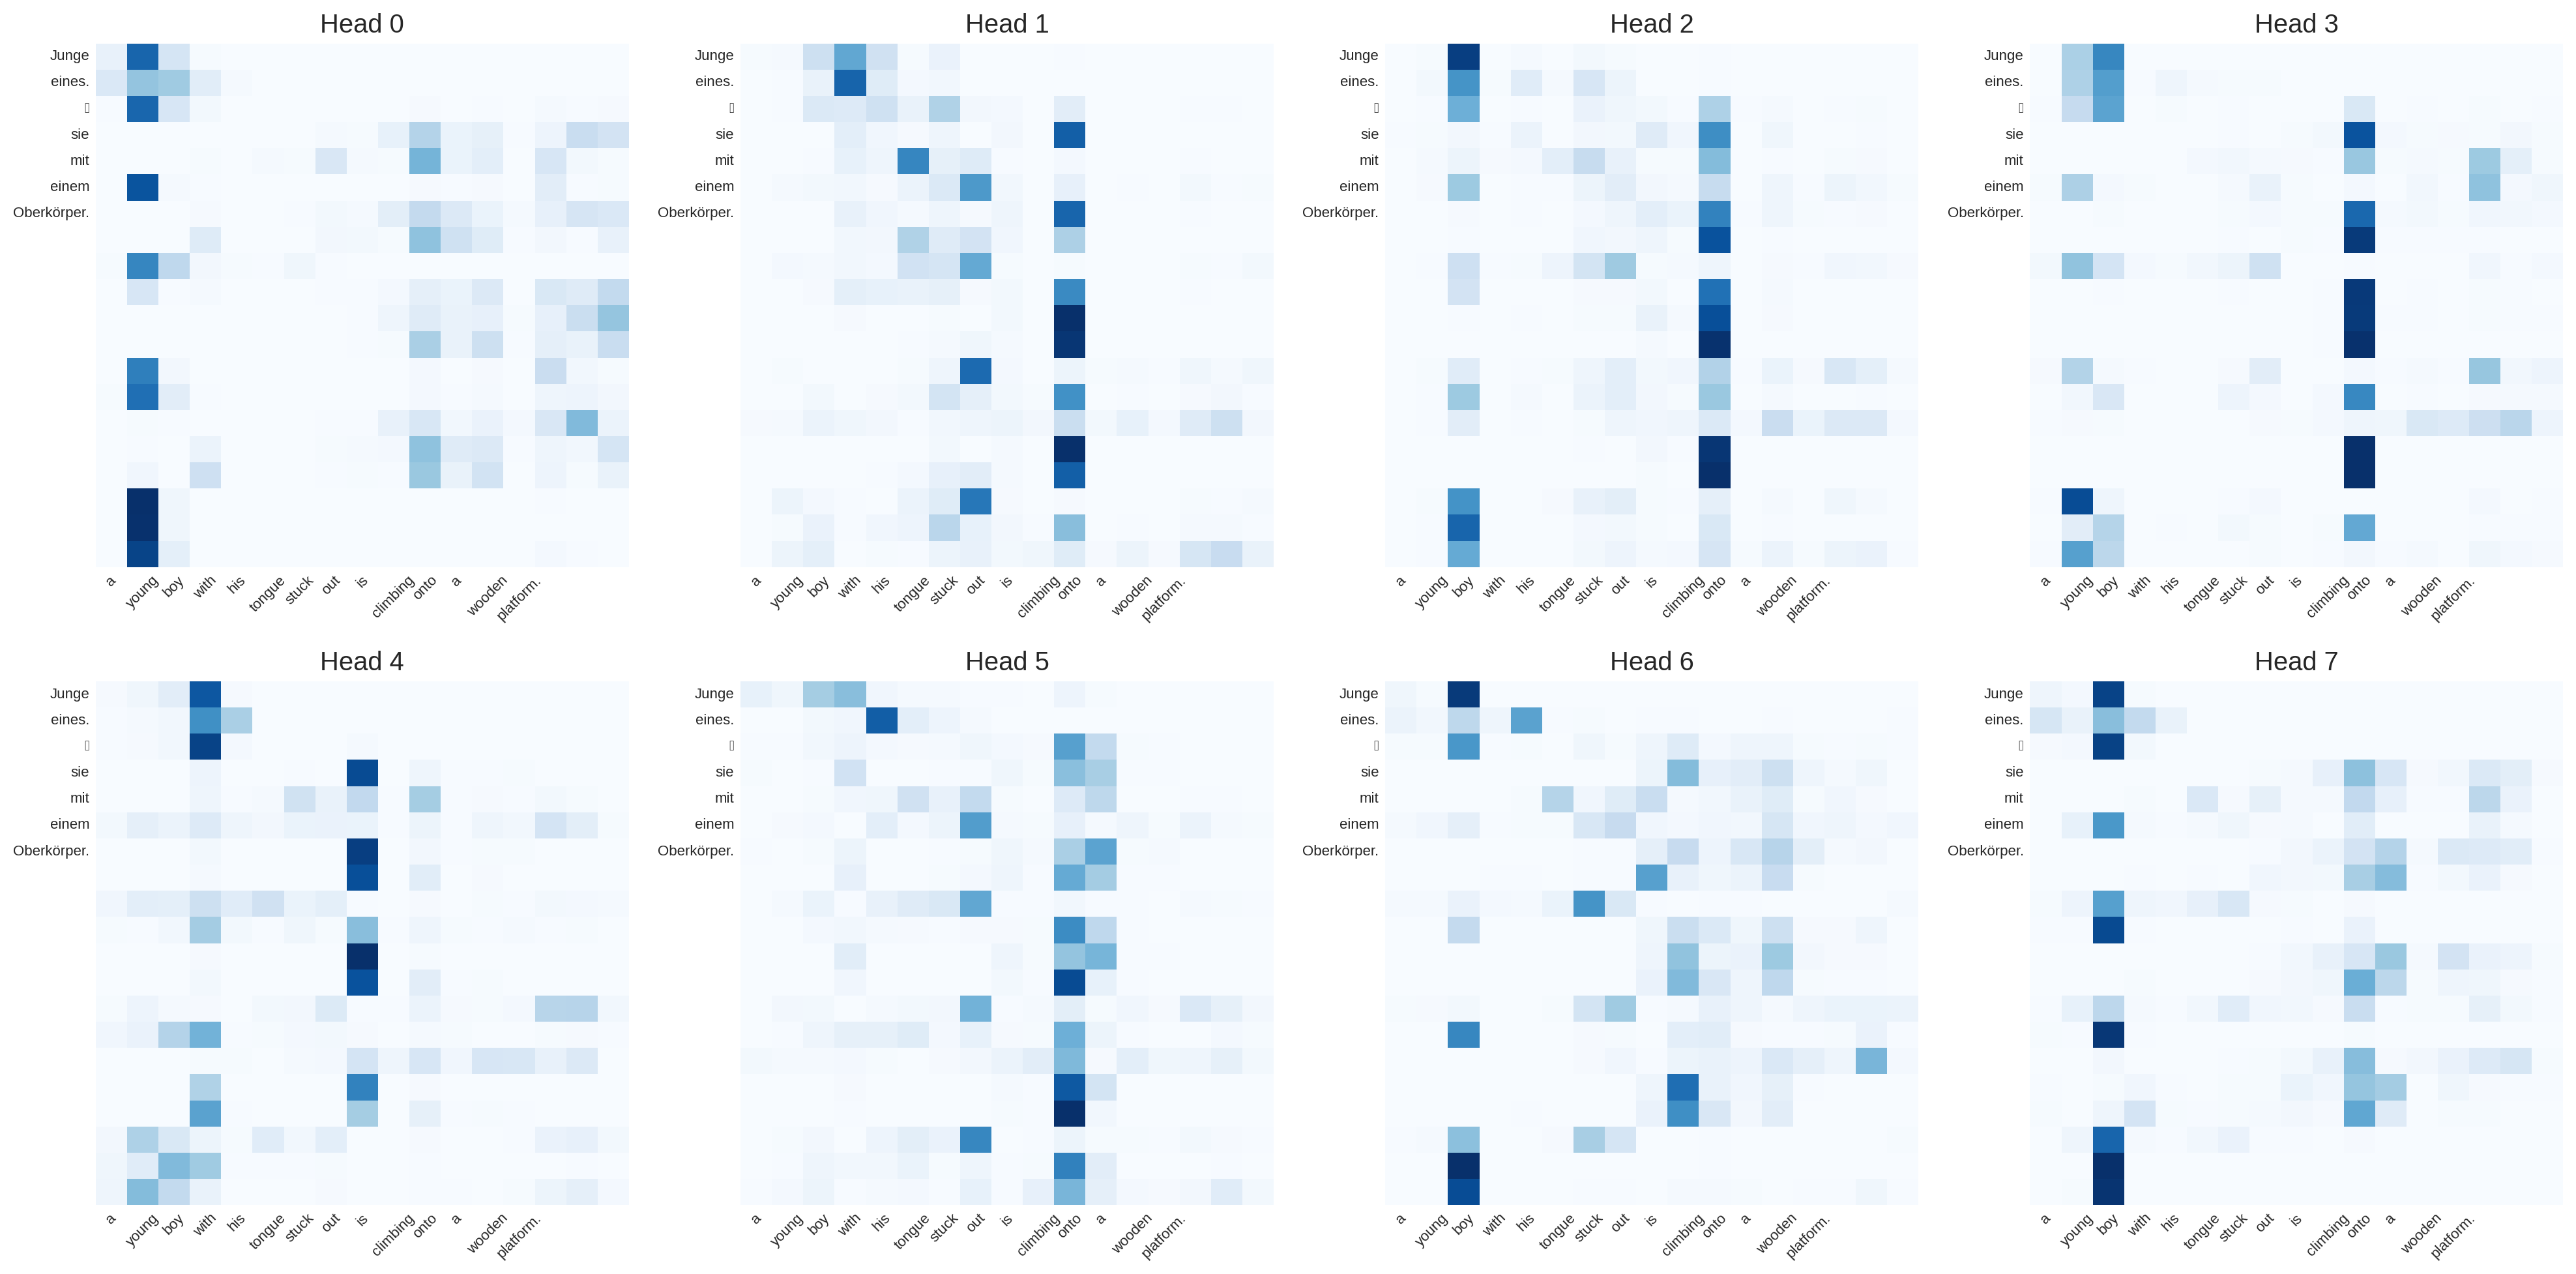

In [61]:
example_idx = 777

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]
predicted, attention_scores = greedy_decode(model, source,len(target))
print("source:", sp.decode(source))
print("target:", sp.decode(target))
print("predicted:", sp.decode(predicted))
plot_attention_scores(source, predicted, attention_scores,MAX_PLOT_LEN = 20)


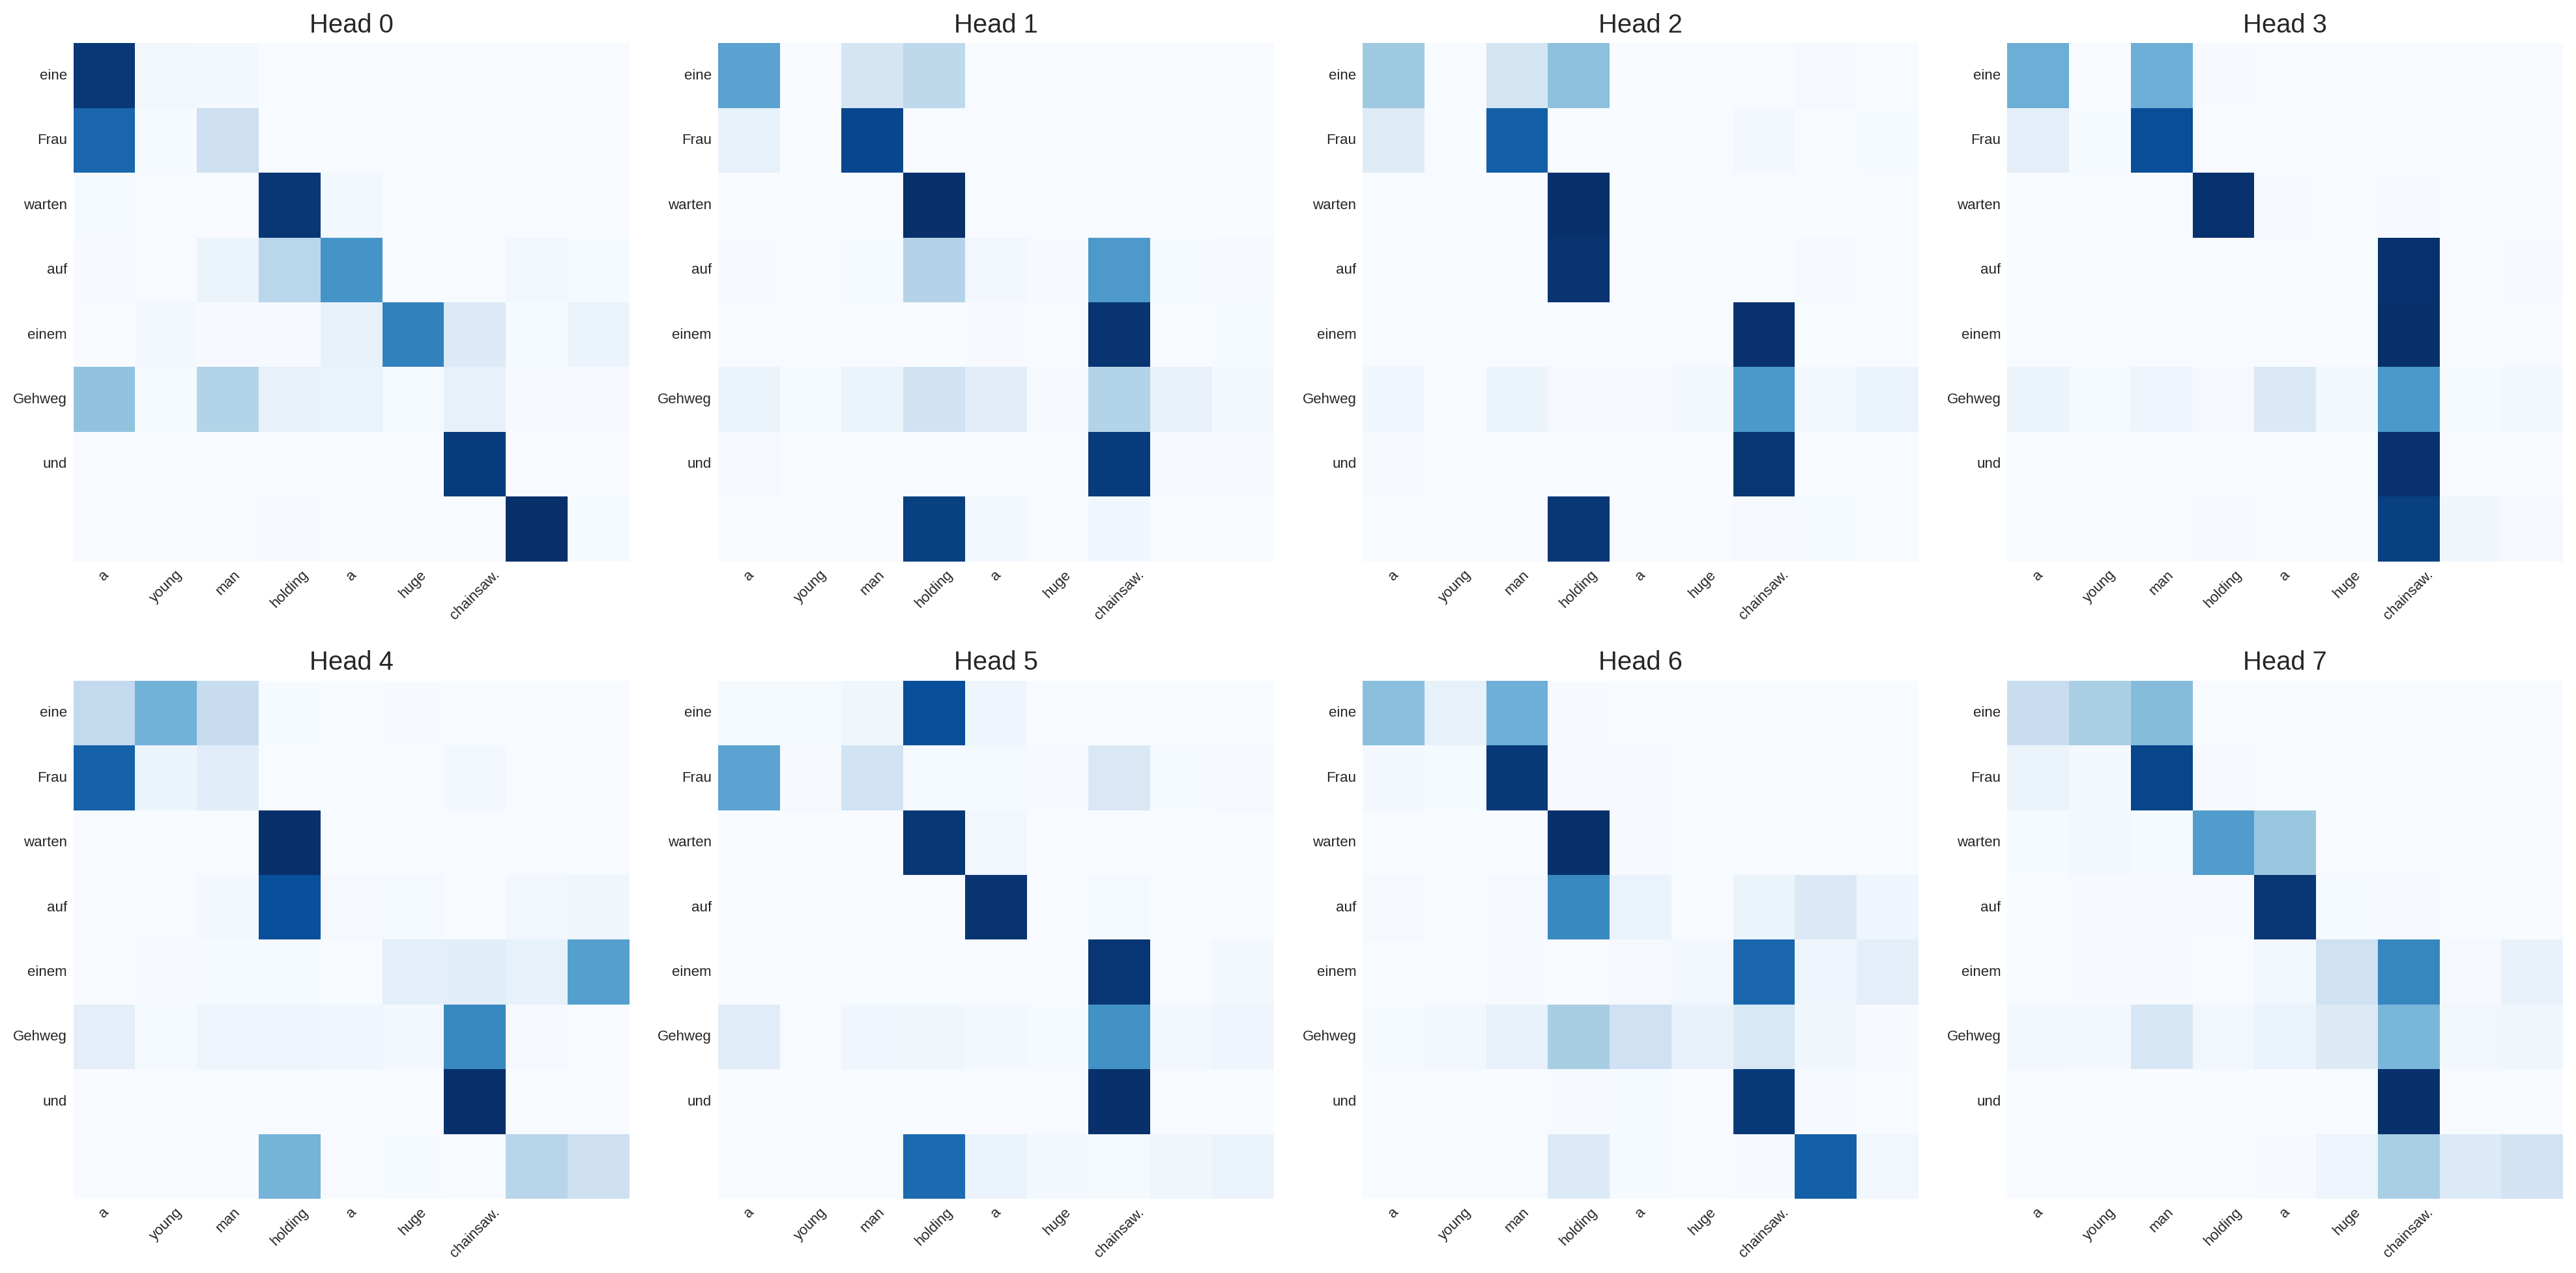

In [62]:
example_idx = 364

source = train_encoded[example_idx]["src"]
target = train_encoded[example_idx]["trg"]

predicted_text,attention_scores = beam_search_decode(
    model,
    source_tokens,
    beam_size=4,
    max_len=len(target),
    length_penalty=0.6,
    min_len=5
)

plot_attention_scores(source, predicted_text, attention_scores,9)
